In [1]:
import numpy
from numpy import dot
from numpy.linalg import norm
import json
import pandas as pd
import copy
import matplotlib.pyplot as plt
import mglearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

# Data preprocessing

In [17]:
with open('한국어능력시험 국가별 지원자 현황(2013_2019).json', 'r') as f:
    json_data = json.load(f)

with open('국적_지역 및 체류자격별 외국인 입국자.json', 'r') as f:
    json_data2 = json.load(f)

check = {}
pred = []
pred_name = []

for j in range(2013, 2019):
    
    key_set1 = []
    key_set2 = []
    
    for i in json_data[str(j)]:
        key_set1.append(i[0].strip().replace(" ", ""))
        i[0] = i[0].replace(" ", "")
        
    for i in json_data2[str(j)]:
        if len(i) > 1:
            key_set2.append(i[0].replace(" ", ""))
            i[0] = i[0].replace(" ", "")
    
    key_set1 = set(key_set1)
    key_set2 = set(key_set2)
    
    key_set1 = key_set1 - (key_set1 - key_set2)
    
    key_set1.add('러시아')
    key_set1.add('대만')
    key_set1.add('태국')
    key_set1.add('아랍에미리트')
    key_set1.add('키르기즈스탄')
    key_set1.add('동티모르')
    key_set1.add('도미니카')
    key_set1.add('벨라루스')
    key_set1.add('코트디브아르')
    key_set1.add('남아프리카공화')
    
    for i in json_data[str(j)]:
        if i[0] in key_set1:
            if i[1] == '':
                check[i[0]+"("+str(j)+")"] = [0]
            else:
                check[i[0]+"("+str(j)+")"] = [int(i[1].strip())]
            
    for i in json_data2[str(j)]:
        
        for k in range(3):
                del i[1]
        
        if type(i[1]) == type('1'):
            for q in range(1, len(i)):
                i[q] = int(i[q])
        
        if len(i) > 1 and i[0] == '러시아(연방)':
            if '러시아'+"("+str(j)+")" in list(check.keys()):
                check['러시아'+"("+str(j)+")"].extend(i)
        elif len(i) > 1 and i[0] == '타이완':
            if '대만'+"("+str(j)+")" in list(check.keys()):
                check['대만'+"("+str(j)+")"].extend(i)
        elif len(i) > 1 and i[0] == '타이':
            if '태국'+"("+str(j)+")" in list(check.keys()):
                check['태국'+"("+str(j)+")"].extend(i)
        elif len(i) > 1 and i[0] == '아랍에미리트연합':
            if '아랍에미리트'+"("+str(j)+")" in list(check.keys()):
                check['아랍에미리트'+"("+str(j)+")"].extend(i)
        elif len(i) > 1 and (i[0] == '키르기즈' or i[0] == '키르기스스탄'):
            if '키르기즈스탄'+"("+str(j)+")" in list(check.keys()):
                check['키르기즈스탄'+"("+str(j)+")"].extend(i)
        elif len(i) > 1 and i[0] == '티모르민주공화국':
            if '동티모르'+"("+str(j)+")" in list(check.keys()):
                check['동티모르'+"("+str(j)+")"].extend(i)        
        elif len(i) > 1 and i[0] == '도미니카공화국':
            if '도미니카'+"("+str(j)+")" in list(check.keys()):
                check['도미니카'+"("+str(j)+")"].extend(i)  
        elif len(i) > 1 and i[0] == '벨로루시':
            if '벨라루스'+"("+str(j)+")" in list(check.keys()):
                check['벨라루스'+"("+str(j)+")"].extend(i)  
        elif len(i) > 1 and i[0] == '코트디부아르':
            if '코트디브아르'+"("+str(j)+")" in list(check.keys()):
                check['코트디브아르'+"("+str(j)+")"].extend(i)  
        elif len(i) > 1 and i[0] == '남아프리카공화국':
            if '남아프리카공화'+"("+str(j)+")" in list(check.keys()):
                check['남아프리카공화'+"("+str(j)+")"].extend(i)   
        else:
            if len(i) > 1:
                if i[0] in key_set1:
                    check[i[0]+"("+str(j)+")"].extend(i)
                else:
                    if j == 2018:
                        pred_name.append(i[0])
                        del i[0]
                        pred.append(i)

del check['대만(2017)']
                        
data = []

for i in list(check.keys()):
    data.append(check[i])

target = []

for i in data:
    target.append(i[0])
    del i[0]

# Data smoothing

In [18]:
target_ = [0] * len(target)

for i in range(len(target)):
    if target[i] <= 10:
        target_[i] = 0
    elif target[i] <= 100:
        target_[i] = 1
    elif target[i] <= 1000:
        target_[i] = 2
    elif target[i] <= 10000:
        target_[i] = 3
    else:
        target_[i] = 4
        
#target_ = numpy.array(target_)

attr = ['외교(A-1)', '공무(A-2)', '사증면제(B-1)', '관광통과(B-2)', '일시취재(C-1)', '단기방문(C-3)', '단기취업(C-4)', '문화예술(D-1)', '구직(D-10)', '유학(D-2)', '기술연수(D-3)', '일반연수(D-4)', '취재(D-5)', '종교(D-6)', '주재(D-7)', '기업투자(D-8)', '무역경영(D-9)', '교수(E-1)', '선원취업(E-10)', '회화(E-2)', '연구(E-3)', '기술지도(E-4)', '전문직업(E-5)', '예술흥행(E-6)', '특정활동(E-7)', '비전문취업(E-9)', '방문동거(F-1)', '거주(F-2)', '동반(F-3)', '재외동포(F-4)', '영주(F-5)', '결혼이민(F-6)', '기타(G-1)', '관광취업(H-1)', '방문취업(H-2)', '관광상륙(T-1)']

#data = numpy.array(data)

# Data optimization

In [15]:
del_set = []
count = 0
for i in range(len(target_)):
    if target_[i-count] == 2:
        del target_[i-count]
        del data[i-count]
        count += 1

# Decision Tree

In [19]:
temp_data = copy.deepcopy(data)

for i in temp_data:
    del i[0]

X_train, X_test, y_train, y_test = train_test_split(temp_data, target_, test_size=0.33, random_state=10)

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': list(range(2, 16)),
    'min_samples_leaf': list(range(1, 6)),
    'min_samples_split': list(range(2, 6)),
    'random_state':[10]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, cv=5)

clf.fit(X_train, y_train)

my_model = clf.best_estimator_
    
base_ = []

for i in range(1, 100):
    
    X_train, X_test, y_train, y_test = train_test_split(temp_data, target_, test_size=0.33, random_state=i)
    
    my_model.fit(X_train, y_train)

    my_model_score_train = my_model.score(X_train, y_train)
    my_model_score_test = my_model.score(X_test, y_test)

    base_.append(my_model_score_test)
    
print(sum(base_)/len(base_))

0.6489587230327969


In [119]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [283]:
factor = list(zip(my_model.feature_importances_, attr))

sorted(factor, key=lambda factor: factor[0])

[(0.0, '일시취재(C-1)'),
 (0.0, '단기방문(C-3)'),
 (0.0, '단기취업(C-4)'),
 (0.0, '구직(D-10)'),
 (0.0, '기술연수(D-3)'),
 (0.0, '취재(D-5)'),
 (0.0, '주재(D-7)'),
 (0.0, '기업투자(D-8)'),
 (0.0, '무역경영(D-9)'),
 (0.0, '교수(E-1)'),
 (0.0, '선원취업(E-10)'),
 (0.0, '회화(E-2)'),
 (0.0, '연구(E-3)'),
 (0.0, '기술지도(E-4)'),
 (0.0, '전문직업(E-5)'),
 (0.0, '예술흥행(E-6)'),
 (0.0, '특정활동(E-7)'),
 (0.0, '동반(F-3)'),
 (0.0, '재외동포(F-4)'),
 (0.0, '결혼이민(F-6)'),
 (0.0, '기타(G-1)'),
 (0.0, '관광취업(H-1)'),
 (0.0, '방문취업(H-2)'),
 (0.0, '관광상륙(T-1)'),
 (0.006773442253799267, '영주(F-5)'),
 (0.008781607286706542, '문화예술(D-1)'),
 (0.00971547876878438, '거주(F-2)'),
 (0.012607945015265049, '비전문취업(E-9)'),
 (0.014153844404363182, '사증면제(B-1)'),
 (0.03550135895444606, '외교(A-1)'),
 (0.03711349442840289, '종교(D-6)'),
 (0.05928251087139093, '관광통과(B-2)'),
 (0.07192405314394698, '공무(A-2)'),
 (0.10334199978971409, '유학(D-2)'),
 (0.19266195685147747, '방문동거(F-1)'),
 (0.4481423082317032, '일반연수(D-4)')]

In [ ]:
list(zip(my_model.predict(pred), pred_name))

# KNN

In [281]:
base_ = []

temp_data = copy.deepcopy(data)

for i in temp_data:
    del i[0]

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    temp = []
    for j in range(1, 100):
        X_train, X_test, y_train, y_test = train_test_split(temp_data, target_, test_size=0.33, random_state=j)
        knn.fit(X_train, y_train)
        temp.append(knn.score(X_test, y_test))
    base_.append([i, sum(temp)/len(temp)])
    
print(base_)

[[1, 0.7695415695415695], [2, 0.7439782439782437], [3, 0.7210567210567207], [4, 0.724242424242424], [5, 0.7229992229992231], [6, 0.7104895104895106], [7, 0.7068376068376067], [8, 0.6983682983682981], [9, 0.6878787878787879]]


# Check similarity between each random_state result

In [261]:
all_country = set()

data_ = []
w_c_set = []

x_wrong_set = []
y_wrong_set = []

x_correct_set = []
y_correct_set = []

wrong_set = ['아제르바이잔', '타지키스탄', '폴란드', '벨로루시', '미얀마']
correct_set = ['헝가리','스리랑카', '그리스', '뉴질랜드', '독일']

for state in range(1, 1000):
    
    X_train, X_test, y_train, y_test = train_test_split(copy.deepcopy(data), target, test_size=0.33, random_state=state)

    data_attr = []
    temp = []
    
    for i in range(len(X_test)):
        data_attr.append(X_test[i][0])
        del X_test[i][0]

    for i in range(len(X_train)):
        del X_train[i][0]
    
    for i in data_attr:
        all_country.add(i)
    data_.append(data_attr)
    
    y_train_ = [0] * len(y_train)
    y_test_ = [0] * len(y_test)
    
    for i in range(len(y_train)):
        if y_train[i] <= 10:
            y_train_[i] = 0
        elif y_train[i] <= 100:
            y_train_[i] = 1
        elif y_train[i] <= 1000:
            y_train_[i] = 2
        elif y_train[i] <= 10000:
            y_train_[i] = 3
        else:
            y_train_[i] = 4
            
    for i in range(len(y_test)):
        if y_test[i] <= 10:
            y_test_[i] = 0
        elif y_test[i] <= 100:
            y_test_[i] = 1
        elif y_test[i] <= 1000:
            y_test_[i] = 2
        elif y_test[i] <= 10000:
            y_test_[i] = 3
        else:
            y_test_[i] = 4

    knn.fit(X_train, y_train_)
    
    for i in list(zip(knn.predict(X_test), y_test_, data_attr, X_test, y_test)):
        if i[0] != i[1]:
            temp.append(0)
            if i[2] in wrong_set:
                x_wrong_set.append(i[3])
                y_wrong_set.append(i[4])
        else:
            temp.append(1)
            if i[2] in correct_set:
                x_correct_set.append(i[3])
                y_correct_set.append(i[4])
            
    w_c_set.append(temp)

all_country = list(all_country)
    
bow = []
    
for i in range(len(data_)):
    temp = [0] * len(all_country)
    for j in range(len(data_[i])):
        if w_c_set[i][j]:
            temp[all_country.index(data_[i][j])] = 1
        else:
            temp[all_country.index(data_[i][j])] = 0
    bow.append(temp)
    
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

simil = []

for i in range(0, len(bow)-1):
    for j in range(i+1, len(bow)):
        simil.append(cos_sim(bow[i], bow[j]))
    
print(sum(simil)/len(simil))

0.6692733478527835


# Prediction success count for each country

In [236]:
sum_set = []

trans_bow = [list(x) for x in zip(*bow)]

for i in trans_bow:
        sum_set.append(sum(i))
        
print(sorted(zip(all_country, sum_set), key=lambda factor: factor[1]))

[('아제르바이잔', 1), ('타지키스탄', 9), ('폴란드', 10), ('벨로루시', 44), ('미얀마', 51), ('베트남', 79), ('아르헨티나', 82), ('러시아(연방)', 122), ('태국', 152), ('노르웨이', 203), ('튀니지', 248), ('요르단', 253), ('파라과이', 273), ('동티모르', 276), ('쿠바', 292), ('캄보디아', 299), ('방글라데시', 303), ('불가리아', 319), ('타이', 324), ('온두라스', 327), ('베네수엘라', 338), ('과테말라', 345), ('파나마', 373), ('아랍에미리트연합', 396), ('조지아', 402), ('인도', 418), ('카자흐스탄', 422), ('파키스탄', 426), ('영국', 441), ('몽골', 448), ('케냐', 466), ('일본', 482), ('이란', 499), ('코스타리카', 499), ('핀란드', 500), ('라오스', 503), ('볼리비아', 510), ('자메이카', 511), ('필리핀', 516), ('인도네시아', 521), ('투르크메니스탄', 534), ('오스트리아', 537), ('나이지리아', 544), ('도미니카공화국', 545), ('모로코', 553), ('사우디아라비아', 568), ('멕시코', 577), ('에티오피아', 585), ('루마니아', 590), ('이집트', 598), ('네팔', 604), ('네덜란드', 620), ('우크라이나', 621), ('타이완', 647), ('티모르민주공화국', 675), ('체코', 712), ('엘살바도르', 719), ('우즈베키스탄', 730), ('브루나이', 737), ('남아프리카공화국', 749), ('이탈리아', 756), ('스페인', 770), ('말레이시아', 777), ('수단', 777), ('중국', 777), ('페루', 778), ('콜롬비아', 778), ('캐나다

# Compare data Characteristic 

# aboout high feature importance attributes 

# between wrong_set / correct_set

# through scatter plot

<function matplotlib.pyplot.show(*args, **kw)>

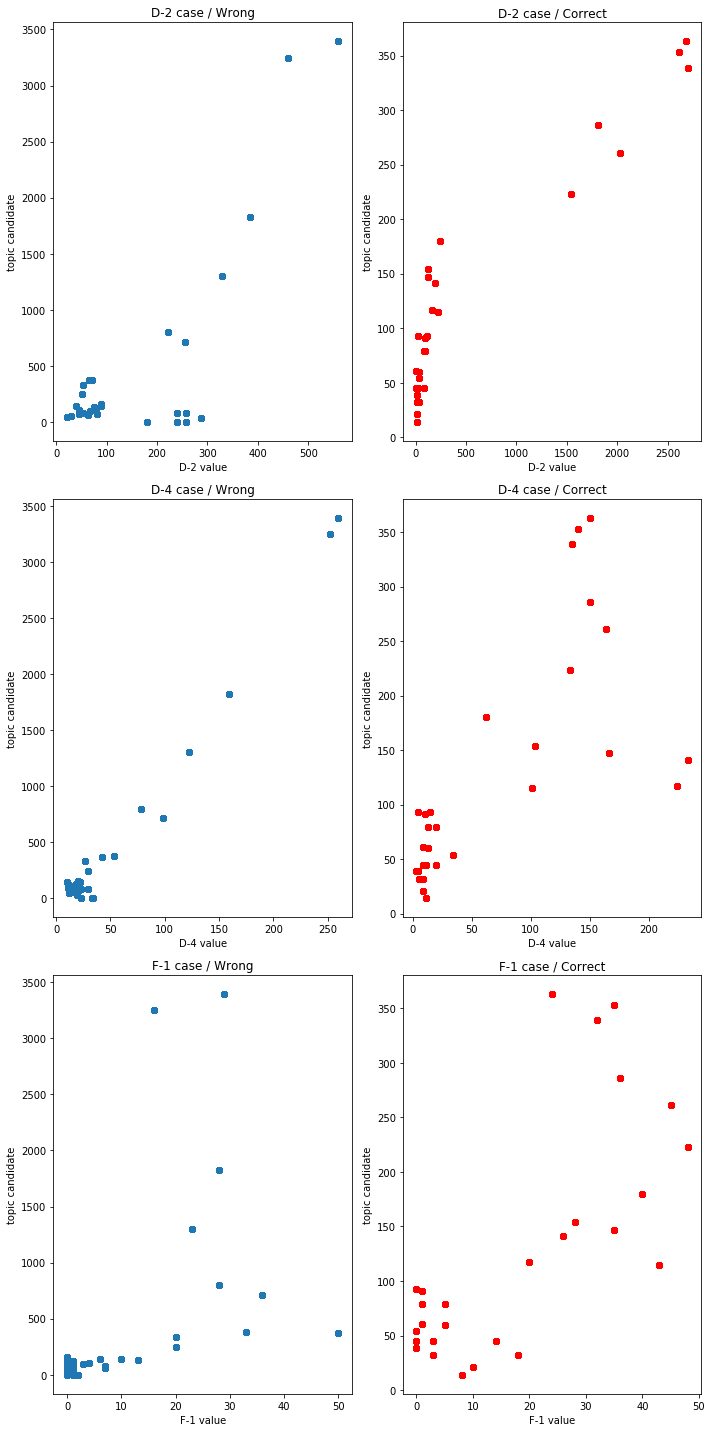

In [262]:
selected_wrong_set = []
selected_correct_set = []

for i in x_wrong_set:
    temp = [i[9], i[11], i[26]]
    selected_wrong_set.append(temp)
    
for i in x_correct_set:
    temp = [i[9], i[11], i[26]]
    selected_correct_set.append(temp)

name = ["D-2", "D-4", "F-1"]
num = [1,3,5]
selected_wrong_set = [list(x) for x in zip(*selected_wrong_set)]
selected_correct_set = [list(x) for x in zip(*selected_correct_set)]

plt.figure(figsize=(10,20))

for i in range(len(name)):
    plt.subplot(3, 2, num[i])
    plt.scatter(selected_wrong_set[i], y_wrong_set)
    plt.title(name[i] + " case / Wrong")
    plt.xlabel(name[i] + " value")
    plt.ylabel("topic candidate")

    plt.subplot(3, 2, num[i]+1)
    plt.scatter(selected_correct_set[i], y_correct_set, c='red')
    plt.title(name[i] + " case / Correct")
    plt.xlabel(name[i] + " value")
    plt.ylabel("topic candidate")
    
plt.tight_layout()    
plt.show

In [313]:
list(zip(knn.predict(pred), pred_name))

[(3, '한국계중국인'),
 (3, '홍콩'),
 (3, '마카오'),
 (2, '이스라엘'),
 (1, '이라크'),
 (1, '쿠웨이트'),
 (1, '카타르'),
 (1, '시리아'),
 (2, '예멘공화국'),
 (1, '오만'),
 (1, '레바논'),
 (2, '바레인'),
 (2, '키프로스'),
 (1, '부탄'),
 (1, '팔레스타인'),
 (1, '몰디브'),
 (1, '남조지아남샌드위치군도'),
 (1, '영령버진아일랜드'),
 (1, '우루과이'),
 (1, '니카라과'),
 (1, '세인트크리스토퍼네비스'),
 (1, '트리니다드토바고'),
 (1, '도미니카연방'),
 (1, '바베이도스'),
 (1, '바하마'),
 (1, '아이티'),
 (1, '앤티카바부다'),
 (1, '그레나다'),
 (1, '가이아나'),
 (1, '수리남'),
 (1, '세인트루시아'),
 (1, '벨리즈'),
 (1, '세인트빈센트그레나딘'),
 (1, '미국인근섬'),
 (1, '보스니아-헤르체고비나'),
 (1, '영국외지민'),
 (1, '영국외지시민'),
 (1, '마케도니아'),
 (2, '한국계러시아인'),
 (2, '스웨덴'),
 (2, '스위스'),
 (1, '벨기에'),
 (1, '덴마크'),
 (1, '아일랜드'),
 (2, '영국보호민'),
 (1, '크로아티아'),
 (1, '슬로바크'),
 (1, '리투아니아'),
 (1, '세르비아'),
 (1, '라트비아'),
 (1, '슬로베니아'),
 (1, '에스토니아'),
 (1, '룩셈부르크'),
 (2, '몬테네그로'),
 (1, '아이슬란드'),
 (2, '알바니아'),
 (2, '유고슬라비아'),
 (1, '몰타'),
 (1, '몰도바'),
 (1, '리히텐슈타인'),
 (1, '코소보'),
 (1, '안도라'),
 (1, '모나코'),
 (1, '산마리노'),
 (1, '교황청'),
 (1, '세르비아몬테네그로'),
 (2, '오스트레일리아'),
 (1, '피지'),
 (2,

# DNN

In [312]:
result = []

temp_data = copy.deepcopy(data)

for i in temp_data:
    del i[0]

for state in range(1, 100):
    X_train, X_test, y_train, y_test = train_test_split(temp_data, target_, test_size=0.33, random_state=state)
    X_train = numpy.array(X_train)
    y_train = to_categorical(y_train)

    model = keras.Sequential()
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    model.fit(X_train, y_train, epochs=300)

    print('Finish training.')

    prediction_class = model.predict_classes(X_test)
    result.append(accuracy_score(y_test, prediction_class))
    
print(sum(result)/len(result))

Epoch 1/300
9/9 [==============================] - 0s 663us/step - loss: 9442.3574
Epoch 2/300
9/9 [==============================] - 0s 994us/step - loss: 5420.2515
Epoch 3/300
9/9 [==============================] - 0s 774us/step - loss: 4030.5334
Epoch 4/300
9/9 [==============================] - 0s 773us/step - loss: 2176.4890
Epoch 5/300
9/9 [==============================] - 0s 887us/step - loss: 1082.9492
Epoch 6/300
9/9 [==============================] - 0s 665us/step - loss: 1519.1818
Epoch 7/300
9/9 [==============================] - 0s 775us/step - loss: 1030.5164
Epoch 8/300
9/9 [==============================] - 0s 780us/step - loss: 1264.0820
Epoch 9/300
9/9 [==============================] - 0s 665us/step - loss: 994.7546
Epoch 10/300
9/9 [==============================] - 0s 776us/step - loss: 669.7533
Epoch 11/300
9/9 [==============================] - 0s 665us/step - loss: 554.1496
Epoch 12/300
9/9 [==============================] - 0s 776us/step - loss: 468.7426
Epoch

9/9 [==============================] - 0s 775us/step - loss: 6.2499
Epoch 200/300
9/9 [==============================] - 0s 776us/step - loss: 9.6011
Epoch 201/300
9/9 [==============================] - 0s 776us/step - loss: 4.0526
Epoch 202/300
9/9 [==============================] - 0s 665us/step - loss: 3.1200
Epoch 203/300
9/9 [==============================] - 0s 666us/step - loss: 4.5574
Epoch 204/300
9/9 [==============================] - 0s 776us/step - loss: 14.4127
Epoch 205/300
9/9 [==============================] - 0s 665us/step - loss: 8.1013
Epoch 206/300
9/9 [==============================] - 0s 665us/step - loss: 10.2476
Epoch 207/300
9/9 [==============================] - 0s 665us/step - loss: 2.7483
Epoch 208/300
9/9 [==============================] - 0s 665us/step - loss: 10.2589
Epoch 209/300
9/9 [==============================] - 0s 557us/step - loss: 20.2414
Epoch 210/300
9/9 [==============================] - 0s 667us/step - loss: 46.3260
Epoch 211/300
9/9 [======

9/9 [==============================] - 0s 776us/step - loss: 13.3316
Epoch 98/300
9/9 [==============================] - 0s 665us/step - loss: 23.9216
Epoch 99/300
9/9 [==============================] - 0s 665us/step - loss: 54.6242
Epoch 100/300
9/9 [==============================] - 0s 665us/step - loss: 80.3516
Epoch 101/300
9/9 [==============================] - 0s 776us/step - loss: 67.3673
Epoch 102/300
9/9 [==============================] - 0s 665us/step - loss: 42.7494
Epoch 103/300
9/9 [==============================] - 0s 776us/step - loss: 21.1587
Epoch 104/300
9/9 [==============================] - 0s 554us/step - loss: 27.0259
Epoch 105/300
9/9 [==============================] - 0s 776us/step - loss: 10.0651
Epoch 106/300
9/9 [==============================] - 0s 665us/step - loss: 17.2607
Epoch 107/300
9/9 [==============================] - 0s 776us/step - loss: 11.6740
Epoch 108/300
9/9 [==============================] - 0s 664us/step - loss: 10.7778
Epoch 109/300
9/9 [=

9/9 [==============================] - 0s 772us/step - loss: 24.4632
Epoch 296/300
9/9 [==============================] - 0s 772us/step - loss: 27.6183
Epoch 297/300
9/9 [==============================] - 0s 776us/step - loss: 20.9471
Epoch 298/300
9/9 [==============================] - 0s 887us/step - loss: 18.9135
Epoch 299/300
9/9 [==============================] - 0s 665us/step - loss: 24.4472
Epoch 300/300
9/9 [==============================] - 0s 776us/step - loss: 8.6365
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 779us/step - loss: 2783.8911
Epoch 2/300
9/9 [==============================] - 0s 663us/step - loss: 1410.0375
Epoch 3/300
9/9 [==============================] - 0s 665us/step - loss: 1217.5659
Epoch 4/300
9/9 [==============================] - 0s 665us/step - loss: 831.0117
Epoch 5/300
9/9 [==============================] - 0s 664us/step - loss: 735.3845
Epoch 6/300
9/9 [==============================] - 0s 775us/step - loss: 657.4567
Epoch

9/9 [==============================] - 0s 554us/step - loss: 200.6851
Epoch 194/300
9/9 [==============================] - 0s 773us/step - loss: 170.7758
Epoch 195/300
9/9 [==============================] - 0s 666us/step - loss: 95.7188
Epoch 196/300
9/9 [==============================] - 0s 776us/step - loss: 50.9017
Epoch 197/300
9/9 [==============================] - 0s 665us/step - loss: 12.7481
Epoch 198/300
9/9 [==============================] - 0s 779us/step - loss: 5.6705
Epoch 199/300
9/9 [==============================] - 0s 665us/step - loss: 9.5264
Epoch 200/300
9/9 [==============================] - 0s 776us/step - loss: 8.4412
Epoch 201/300
9/9 [==============================] - 0s 776us/step - loss: 13.5034
Epoch 202/300
9/9 [==============================] - 0s 776us/step - loss: 19.0352
Epoch 203/300
9/9 [==============================] - 0s 779us/step - loss: 6.1018
Epoch 204/300
9/9 [==============================] - 0s 668us/step - loss: 7.5796
Epoch 205/300
9/9 [==

9/9 [==============================] - 0s 776us/step - loss: 20.0447
Epoch 92/300
9/9 [==============================] - 0s 663us/step - loss: 23.2014
Epoch 93/300
9/9 [==============================] - 0s 660us/step - loss: 44.3176
Epoch 94/300
9/9 [==============================] - 0s 776us/step - loss: 14.7857
Epoch 95/300
9/9 [==============================] - 0s 772us/step - loss: 7.5977
Epoch 96/300
9/9 [==============================] - 0s 662us/step - loss: 16.0863
Epoch 97/300
9/9 [==============================] - 0s 773us/step - loss: 21.1910
Epoch 98/300
9/9 [==============================] - 0s 665us/step - loss: 277.6344
Epoch 99/300
9/9 [==============================] - 0s 776us/step - loss: 465.1363
Epoch 100/300
9/9 [==============================] - 0s 558us/step - loss: 204.9079
Epoch 101/300
9/9 [==============================] - 0s 776us/step - loss: 49.0049
Epoch 102/300
9/9 [==============================] - 0s 662us/step - loss: 75.6223
Epoch 103/300
9/9 [=====

Epoch 290/300
9/9 [==============================] - 0s 665us/step - loss: 14.9812
Epoch 291/300
9/9 [==============================] - 0s 665us/step - loss: 6.3609
Epoch 292/300
9/9 [==============================] - 0s 773us/step - loss: 25.2073
Epoch 293/300
9/9 [==============================] - 0s 665us/step - loss: 13.1687
Epoch 294/300
9/9 [==============================] - 0s 772us/step - loss: 18.9781
Epoch 295/300
9/9 [==============================] - 0s 551us/step - loss: 8.8628
Epoch 296/300
9/9 [==============================] - 0s 662us/step - loss: 3.2821
Epoch 297/300
9/9 [==============================] - 0s 554us/step - loss: 5.4736
Epoch 298/300
9/9 [==============================] - 0s 773us/step - loss: 12.8649
Epoch 299/300
9/9 [==============================] - 0s 553us/step - loss: 18.1136
Epoch 300/300
9/9 [==============================] - 0s 554us/step - loss: 9.0832
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 668us/step - loss: 91

9/9 [==============================] - 0s 995us/step - loss: 29.3551
Epoch 189/300
9/9 [==============================] - 0s 888us/step - loss: 4.1198
Epoch 190/300
9/9 [==============================] - 0s 887us/step - loss: 26.7912
Epoch 191/300
9/9 [==============================] - 0s 997us/step - loss: 5.0159
Epoch 192/300
9/9 [==============================] - 0s 997us/step - loss: 4.7079
Epoch 193/300
9/9 [==============================] - 0s 997us/step - loss: 5.8556
Epoch 194/300
9/9 [==============================] - 0s 1ms/step - loss: 16.2651
Epoch 195/300
9/9 [==============================] - 0s 887us/step - loss: 6.4709
Epoch 196/300
9/9 [==============================] - 0s 887us/step - loss: 11.8716
Epoch 197/300
9/9 [==============================] - 0s 886us/step - loss: 5.6527
Epoch 198/300
9/9 [==============================] - 0s 887us/step - loss: 9.0305
Epoch 199/300
9/9 [==============================] - 0s 886us/step - loss: 34.2988
Epoch 200/300
9/9 [========

9/9 [==============================] - 0s 997us/step - loss: 15.3929
Epoch 288/300
9/9 [==============================] - 0s 997us/step - loss: 17.1835
Epoch 289/300
9/9 [==============================] - 0s 997us/step - loss: 18.7108
Epoch 290/300
9/9 [==============================] - ETA: 0s - loss: 12.72 - 0s 997us/step - loss: 11.9072
Epoch 291/300
9/9 [==============================] - 0s 998us/step - loss: 6.0637
Epoch 292/300
9/9 [==============================] - 0s 1ms/step - loss: 5.3155
Epoch 293/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3290
Epoch 294/300
9/9 [==============================] - 0s 995us/step - loss: 3.6971
Epoch 295/300
9/9 [==============================] - 0s 889us/step - loss: 3.1555
Epoch 296/300
9/9 [==============================] - 0s 997us/step - loss: 2.6226
Epoch 297/300
9/9 [==============================] - 0s 995us/step - loss: 1.2379
Epoch 298/300
9/9 [==============================] - 0s 886us/step - loss: 1.1341
Epoch 

9/9 [==============================] - 0s 997us/step - loss: 3.0732
Epoch 187/300
9/9 [==============================] - 0s 998us/step - loss: 4.8732
Epoch 188/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6490
Epoch 189/300
9/9 [==============================] - 0s 1ms/step - loss: 7.4658
Epoch 190/300
9/9 [==============================] - 0s 1ms/step - loss: 5.3178
Epoch 191/300
9/9 [==============================] - 0s 1ms/step - loss: 45.3725
Epoch 192/300
9/9 [==============================] - 0s 1000us/step - loss: 45.6444
Epoch 193/300
9/9 [==============================] - 0s 1ms/step - loss: 20.6548
Epoch 194/300
9/9 [==============================] - 0s 997us/step - loss: 65.8180
Epoch 195/300
9/9 [==============================] - 0s 997us/step - loss: 71.0150
Epoch 196/300
9/9 [==============================] - 0s 997us/step - loss: 38.4193
Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 48.3826
Epoch 198/300
9/9 [===============

9/9 [==============================] - 0s 997us/step - loss: 113.4580
Epoch 85/300
9/9 [==============================] - 0s 889us/step - loss: 230.6413
Epoch 86/300
9/9 [==============================] - 0s 997us/step - loss: 60.9939
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 53.2438
Epoch 88/300
9/9 [==============================] - 0s 1000us/step - loss: 71.0578
Epoch 89/300
9/9 [==============================] - 0s 1ms/step - loss: 22.1097
Epoch 90/300
9/9 [==============================] - 0s 997us/step - loss: 21.2457
Epoch 91/300
9/9 [==============================] - 0s 997us/step - loss: 16.1436
Epoch 92/300
9/9 [==============================] - 0s 1000us/step - loss: 14.2414
Epoch 93/300
9/9 [==============================] - 0s 1000us/step - loss: 17.2865
Epoch 94/300
9/9 [==============================] - 0s 998us/step - loss: 12.8281
Epoch 95/300
9/9 [==============================] - 0s 997us/step - loss: 12.7523
Epoch 96/300
9/9 [==========

Epoch 184/300
9/9 [==============================] - 0s 2ms/step - loss: 16.8153
Epoch 185/300
9/9 [==============================] - 0s 2ms/step - loss: 18.6040
Epoch 186/300
9/9 [==============================] - 0s 2ms/step - loss: 19.4228
Epoch 187/300
9/9 [==============================] - 0s 2ms/step - loss: 18.1538
Epoch 188/300
9/9 [==============================] - 0s 4ms/step - loss: 27.0691
Epoch 189/300
9/9 [==============================] - 0s 2ms/step - loss: 44.3625
Epoch 190/300
9/9 [==============================] - 0s 2ms/step - loss: 40.2134
Epoch 191/300
9/9 [==============================] - 0s 2ms/step - loss: 68.7578
Epoch 192/300
9/9 [==============================] - 0s 2ms/step - loss: 27.5699
Epoch 193/300
9/9 [==============================] - 0s 2ms/step - loss: 10.9189
Epoch 194/300
9/9 [==============================] - 0s 2ms/step - loss: 12.5232
Epoch 195/300
9/9 [==============================] - 0s 2ms/step - loss: 11.4747
Epoch 196/300
9/9 [=========

9/9 [==============================] - 0s 887us/step - loss: 6.4911
Epoch 85/300
9/9 [==============================] - 0s 1ms/step - loss: 5.8184
Epoch 86/300
9/9 [==============================] - 0s 998us/step - loss: 9.2667
Epoch 87/300
9/9 [==============================] - 0s 997us/step - loss: 34.7697
Epoch 88/300
9/9 [==============================] - 0s 889us/step - loss: 36.4878
Epoch 89/300
9/9 [==============================] - 0s 887us/step - loss: 8.0175
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 7.3964
Epoch 91/300
9/9 [==============================] - 0s 886us/step - loss: 22.3774
Epoch 92/300
9/9 [==============================] - 0s 889us/step - loss: 10.1812
Epoch 93/300
9/9 [==============================] - 0s 997us/step - loss: 25.1793
Epoch 94/300
9/9 [==============================] - 0s 884us/step - loss: 9.6589
Epoch 95/300
9/9 [==============================] - 0s 889us/step - loss: 8.8206
Epoch 96/300
9/9 [======================

9/9 [==============================] - 0s 1ms/step - loss: 1.4961
Epoch 284/300
9/9 [==============================] - 0s 1ms/step - loss: 1.0003
Epoch 285/300
9/9 [==============================] - 0s 997us/step - loss: 0.8972
Epoch 286/300
9/9 [==============================] - 0s 997us/step - loss: 1.2296
Epoch 287/300
9/9 [==============================] - 0s 1ms/step - loss: 1.3150
Epoch 288/300
9/9 [==============================] - 0s 1ms/step - loss: 1.1879
Epoch 289/300
9/9 [==============================] - 0s 998us/step - loss: 0.7669
Epoch 290/300
9/9 [==============================] - 0s 997us/step - loss: 0.7904
Epoch 291/300
9/9 [==============================] - 0s 1ms/step - loss: 0.7422
Epoch 292/300
9/9 [==============================] - 0s 1000us/step - loss: 0.8618
Epoch 293/300
9/9 [==============================] - 0s 997us/step - loss: 0.9142
Epoch 294/300
9/9 [==============================] - 0s 1000us/step - loss: 1.0418
Epoch 295/300
9/9 [===================

Epoch 182/300
9/9 [==============================] - 0s 1ms/step - loss: 28.7582
Epoch 183/300
9/9 [==============================] - 0s 1ms/step - loss: 8.1829
Epoch 184/300
9/9 [==============================] - 0s 889us/step - loss: 25.5184
Epoch 185/300
9/9 [==============================] - 0s 1ms/step - loss: 319.6412
Epoch 186/300
9/9 [==============================] - 0s 997us/step - loss: 88.1393
Epoch 187/300
9/9 [==============================] - 0s 997us/step - loss: 225.0134
Epoch 188/300
9/9 [==============================] - 0s 997us/step - loss: 487.1004
Epoch 189/300
9/9 [==============================] - 0s 889us/step - loss: 532.7916
Epoch 190/300
9/9 [==============================] - 0s 887us/step - loss: 356.6273
Epoch 191/300
9/9 [==============================] - 0s 997us/step - loss: 177.9365
Epoch 192/300
9/9 [==============================] - 0s 997us/step - loss: 140.6664
Epoch 193/300
9/9 [==============================] - 0s 886us/step - loss: 59.0081
Epoc

9/9 [==============================] - 0s 997us/step - loss: 12.7581
Epoch 82/300
9/9 [==============================] - 0s 886us/step - loss: 13.5603
Epoch 83/300
9/9 [==============================] - 0s 886us/step - loss: 11.9813
Epoch 84/300
9/9 [==============================] - 0s 998us/step - loss: 17.0805
Epoch 85/300
9/9 [==============================] - 0s 887us/step - loss: 8.7737
Epoch 86/300
9/9 [==============================] - 0s 997us/step - loss: 5.5102
Epoch 87/300
9/9 [==============================] - 0s 997us/step - loss: 14.5700
Epoch 88/300
9/9 [==============================] - 0s 887us/step - loss: 21.1352
Epoch 89/300
9/9 [==============================] - 0s 886us/step - loss: 13.8769
Epoch 90/300
9/9 [==============================] - 0s 997us/step - loss: 10.0140
Epoch 91/300
9/9 [==============================] - 0s 998us/step - loss: 6.4467
Epoch 92/300
9/9 [==============================] - 0s 886us/step - loss: 6.7790
Epoch 93/300
9/9 [===============

9/9 [==============================] - 0s 997us/step - loss: 0.9451
Epoch 281/300
9/9 [==============================] - 0s 888us/step - loss: 1.5973
Epoch 282/300
9/9 [==============================] - 0s 997us/step - loss: 0.9789
Epoch 283/300
9/9 [==============================] - 0s 997us/step - loss: 0.7046
Epoch 284/300
9/9 [==============================] - 0s 997us/step - loss: 0.7346
Epoch 285/300
9/9 [==============================] - 0s 887us/step - loss: 1.2230
Epoch 286/300
9/9 [==============================] - 0s 886us/step - loss: 1.7003
Epoch 287/300
9/9 [==============================] - 0s 997us/step - loss: 1.0667
Epoch 288/300
9/9 [==============================] - 0s 776us/step - loss: 0.8001
Epoch 289/300
9/9 [==============================] - 0s 886us/step - loss: 0.6432
Epoch 290/300
9/9 [==============================] - 0s 887us/step - loss: 0.6292
Epoch 291/300
9/9 [==============================] - 0s 887us/step - loss: 0.5657
Epoch 292/300
9/9 [===========

9/9 [==============================] - 0s 997us/step - loss: 4.1478
Epoch 179/300
9/9 [==============================] - 0s 997us/step - loss: 11.5131
Epoch 180/300
9/9 [==============================] - 0s 887us/step - loss: 8.6533
Epoch 181/300
9/9 [==============================] - 0s 998us/step - loss: 6.5316
Epoch 182/300
9/9 [==============================] - 0s 997us/step - loss: 4.8699
Epoch 183/300
9/9 [==============================] - 0s 997us/step - loss: 12.9659
Epoch 184/300
9/9 [==============================] - 0s 1ms/step - loss: 11.6841
Epoch 185/300
9/9 [==============================] - 0s 1ms/step - loss: 10.9695
Epoch 186/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8312
Epoch 187/300
9/9 [==============================] - 0s 1ms/step - loss: 7.3384
Epoch 188/300
9/9 [==============================] - 0s 1ms/step - loss: 5.3325
Epoch 189/300
9/9 [==============================] - 0s 997us/step - loss: 21.7977
Epoch 190/300
9/9 [================

9/9 [==============================] - 0s 1ms/step - loss: 13.8840
Epoch 78/300
9/9 [==============================] - 0s 1ms/step - loss: 10.4084
Epoch 79/300
9/9 [==============================] - 0s 1ms/step - loss: 16.8758
Epoch 80/300
9/9 [==============================] - 0s 998us/step - loss: 11.6982
Epoch 81/300
9/9 [==============================] - 0s 887us/step - loss: 14.8258
Epoch 82/300
9/9 [==============================] - 0s 997us/step - loss: 12.0314
Epoch 83/300
9/9 [==============================] - 0s 1ms/step - loss: 13.5921
Epoch 84/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2212
Epoch 85/300
9/9 [==============================] - 0s 887us/step - loss: 11.0541
Epoch 86/300
9/9 [==============================] - 0s 1ms/step - loss: 13.1769
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 32.0505
Epoch 88/300
9/9 [==============================] - 0s 997us/step - loss: 22.6347
Epoch 89/300
9/9 [=========================

9/9 [==============================] - 0s 776us/step - loss: 4.2282
Epoch 277/300
9/9 [==============================] - 0s 886us/step - loss: 2.6201
Epoch 278/300
9/9 [==============================] - 0s 886us/step - loss: 1.7641
Epoch 279/300
9/9 [==============================] - 0s 887us/step - loss: 2.2808
Epoch 280/300
9/9 [==============================] - 0s 887us/step - loss: 1.7476
Epoch 281/300
9/9 [==============================] - 0s 997us/step - loss: 1.6739
Epoch 282/300
9/9 [==============================] - 0s 997us/step - loss: 1.4749
Epoch 283/300
9/9 [==============================] - 0s 886us/step - loss: 1.5139
Epoch 284/300
9/9 [==============================] - 0s 997us/step - loss: 1.4579
Epoch 285/300
9/9 [==============================] - 0s 887us/step - loss: 1.3029
Epoch 286/300
9/9 [==============================] - 0s 775us/step - loss: 1.2425
Epoch 287/300
9/9 [==============================] - 0s 997us/step - loss: 1.2422
Epoch 288/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 3.6045
Epoch 176/300
9/9 [==============================] - 0s 997us/step - loss: 3.1863
Epoch 177/300
9/9 [==============================] - 0s 997us/step - loss: 1.4263
Epoch 178/300
9/9 [==============================] - 0s 998us/step - loss: 2.0636
Epoch 179/300
9/9 [==============================] - 0s 886us/step - loss: 1.8744
Epoch 180/300
9/9 [==============================] - 0s 887us/step - loss: 1.3816
Epoch 181/300
9/9 [==============================] - 0s 887us/step - loss: 6.2914
Epoch 182/300
9/9 [==============================] - 0s 886us/step - loss: 12.6274
Epoch 183/300
9/9 [==============================] - 0s 997us/step - loss: 6.3774
Epoch 184/300
9/9 [==============================] - 0s 886us/step - loss: 8.0610
Epoch 185/300
9/9 [==============================] - 0s 886us/step - loss: 16.3811
Epoch 186/300
9/9 [==============================] - 0s 997us/step - loss: 24.5935
Epoch 187/300
9/9 [==========

9/9 [==============================] - 0s 1ms/step - loss: 1.9871
Epoch 276/300
9/9 [==============================] - 0s 998us/step - loss: 3.1390
Epoch 277/300
9/9 [==============================] - 0s 998us/step - loss: 0.5573
Epoch 278/300
9/9 [==============================] - 0s 997us/step - loss: 0.5999
Epoch 279/300
9/9 [==============================] - 0s 886us/step - loss: 0.8213
Epoch 280/300
9/9 [==============================] - 0s 889us/step - loss: 0.3961
Epoch 281/300
9/9 [==============================] - 0s 997us/step - loss: 0.5507
Epoch 282/300
9/9 [==============================] - 0s 997us/step - loss: 0.4461
Epoch 283/300
9/9 [==============================] - 0s 1ms/step - loss: 0.5490
Epoch 284/300
9/9 [==============================] - 0s 889us/step - loss: 0.6485
Epoch 285/300
9/9 [==============================] - 0s 887us/step - loss: 0.4508
Epoch 286/300
9/9 [==============================] - 0s 997us/step - loss: 0.4091
Epoch 287/300
9/9 [===============

9/9 [==============================] - 0s 886us/step - loss: 26.7382
Epoch 174/300
9/9 [==============================] - 0s 997us/step - loss: 18.5909
Epoch 175/300
9/9 [==============================] - 0s 890us/step - loss: 18.8748
Epoch 176/300
9/9 [==============================] - 0s 997us/step - loss: 14.3515
Epoch 177/300
9/9 [==============================] - 0s 995us/step - loss: 9.1637
Epoch 178/300
9/9 [==============================] - 0s 997us/step - loss: 6.3996
Epoch 179/300
9/9 [==============================] - 0s 886us/step - loss: 3.6654
Epoch 180/300
9/9 [==============================] - 0s 1000us/step - loss: 4.3273
Epoch 181/300
9/9 [==============================] - 0s 997us/step - loss: 3.8192
Epoch 182/300
9/9 [==============================] - 0s 1000us/step - loss: 2.6326
Epoch 183/300
9/9 [==============================] - 0s 997us/step - loss: 4.0609
Epoch 184/300
9/9 [==============================] - 0s 997us/step - loss: 3.8004
Epoch 185/300
9/9 [=====

9/9 [==============================] - 0s 886us/step - loss: 105.5671
Epoch 72/300
9/9 [==============================] - 0s 887us/step - loss: 119.8573
Epoch 73/300
9/9 [==============================] - 0s 997us/step - loss: 66.1587
Epoch 74/300
9/9 [==============================] - 0s 886us/step - loss: 52.3675
Epoch 75/300
9/9 [==============================] - 0s 887us/step - loss: 43.4767
Epoch 76/300
9/9 [==============================] - 0s 889us/step - loss: 31.4754
Epoch 77/300
9/9 [==============================] - 0s 889us/step - loss: 36.6496
Epoch 78/300
9/9 [==============================] - 0s 889us/step - loss: 255.0099
Epoch 79/300
9/9 [==============================] - 0s 887us/step - loss: 214.0725
Epoch 80/300
9/9 [==============================] - 0s 890us/step - loss: 150.1624
Epoch 81/300
9/9 [==============================] - 0s 887us/step - loss: 77.7837
Epoch 82/300
9/9 [==============================] - 0s 778us/step - loss: 42.0526
Epoch 83/300
9/9 [======

9/9 [==============================] - 0s 1000us/step - loss: 19.9703
Epoch 271/300
9/9 [==============================] - 0s 1000us/step - loss: 8.2143
Epoch 272/300
9/9 [==============================] - 0s 1ms/step - loss: 13.6268
Epoch 273/300
9/9 [==============================] - 0s 1ms/step - loss: 37.2692
Epoch 274/300
9/9 [==============================] - 0s 1ms/step - loss: 27.7821
Epoch 275/300
9/9 [==============================] - 0s 997us/step - loss: 4.3131
Epoch 276/300
9/9 [==============================] - 0s 1ms/step - loss: 27.2284
Epoch 277/300
9/9 [==============================] - 0s 1ms/step - loss: 15.8337
Epoch 278/300
9/9 [==============================] - 0s 1ms/step - loss: 6.0175
Epoch 279/300
9/9 [==============================] - 0s 1ms/step - loss: 14.0044
Epoch 280/300
9/9 [==============================] - 0s 1ms/step - loss: 27.1916
Epoch 281/300
9/9 [==============================] - 0s 1ms/step - loss: 8.3719
Epoch 282/300
9/9 [===================

Epoch 71/300
9/9 [==============================] - 0s 1ms/step - loss: 15.8427
Epoch 72/300
9/9 [==============================] - 0s 1ms/step - loss: 21.7686
Epoch 73/300
9/9 [==============================] - 0s 1ms/step - loss: 18.4607
Epoch 74/300
9/9 [==============================] - 0s 1ms/step - loss: 13.2543
Epoch 75/300
9/9 [==============================] - 0s 1ms/step - loss: 18.6798
Epoch 76/300
9/9 [==============================] - 0s 1ms/step - loss: 27.1658
Epoch 77/300
9/9 [==============================] - 0s 997us/step - loss: 35.5554
Epoch 78/300
9/9 [==============================] - 0s 1ms/step - loss: 26.1262
Epoch 79/300
9/9 [==============================] - 0s 1ms/step - loss: 25.0127
Epoch 80/300
9/9 [==============================] - 0s 1ms/step - loss: 32.8575
Epoch 81/300
9/9 [==============================] - 0s 1ms/step - loss: 23.0293
Epoch 82/300
9/9 [==============================] - 0s 1ms/step - loss: 68.8268
Epoch 83/300
9/9 [====================

9/9 [==============================] - 0s 998us/step - loss: 8.5144
Epoch 271/300
9/9 [==============================] - 0s 1ms/step - loss: 4.7850
Epoch 272/300
9/9 [==============================] - 0s 997us/step - loss: 2.9208
Epoch 273/300
9/9 [==============================] - 0s 890us/step - loss: 4.2259
Epoch 274/300
9/9 [==============================] - 0s 997us/step - loss: 3.4919
Epoch 275/300
9/9 [==============================] - 0s 997us/step - loss: 2.9338
Epoch 276/300
9/9 [==============================] - 0s 890us/step - loss: 2.4680
Epoch 277/300
9/9 [==============================] - 0s 998us/step - loss: 3.9038
Epoch 278/300
9/9 [==============================] - 0s 997us/step - loss: 13.0972
Epoch 279/300
9/9 [==============================] - 0s 998us/step - loss: 4.3157
Epoch 280/300
9/9 [==============================] - 0s 886us/step - loss: 8.9072
Epoch 281/300
9/9 [==============================] - 0s 998us/step - loss: 3.0383
Epoch 282/300
9/9 [============

9/9 [==============================] - 0s 1ms/step - loss: 6.2766
Epoch 170/300
9/9 [==============================] - 0s 997us/step - loss: 4.0377
Epoch 171/300
9/9 [==============================] - 0s 1ms/step - loss: 4.4085
Epoch 172/300
9/9 [==============================] - 0s 1ms/step - loss: 2.7113
Epoch 173/300
9/9 [==============================] - 0s 997us/step - loss: 2.9567
Epoch 174/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3443
Epoch 175/300
9/9 [==============================] - 0s 1ms/step - loss: 2.8904
Epoch 176/300
9/9 [==============================] - 0s 997us/step - loss: 3.5168
Epoch 177/300
9/9 [==============================] - 0s 997us/step - loss: 5.4719
Epoch 178/300
9/9 [==============================] - 0s 997us/step - loss: 2.9542
Epoch 179/300
9/9 [==============================] - 0s 998us/step - loss: 2.6342
Epoch 180/300
9/9 [==============================] - 0s 886us/step - loss: 2.7121
Epoch 181/300
9/9 [=====================

9/9 [==============================] - 0s 997us/step - loss: 16.5150
Epoch 68/300
9/9 [==============================] - 0s 998us/step - loss: 42.9535
Epoch 69/300
9/9 [==============================] - 0s 1ms/step - loss: 91.7756
Epoch 70/300
9/9 [==============================] - 0s 1ms/step - loss: 80.1461
Epoch 71/300
9/9 [==============================] - 0s 889us/step - loss: 179.6056
Epoch 72/300
9/9 [==============================] - 0s 997us/step - loss: 138.2326
Epoch 73/300
9/9 [==============================] - 0s 997us/step - loss: 54.5575
Epoch 74/300
9/9 [==============================] - 0s 997us/step - loss: 186.0173
Epoch 75/300
9/9 [==============================] - 0s 887us/step - loss: 227.9349
Epoch 76/300
9/9 [==============================] - 0s 889us/step - loss: 85.5721
Epoch 77/300
9/9 [==============================] - 0s 1ms/step - loss: 80.3481
Epoch 78/300
9/9 [==============================] - 0s 997us/step - loss: 23.9808
Epoch 79/300
9/9 [=============

Epoch 167/300
9/9 [==============================] - 0s 997us/step - loss: 10.3508
Epoch 168/300
9/9 [==============================] - 0s 997us/step - loss: 16.7601
Epoch 169/300
9/9 [==============================] - 0s 1ms/step - loss: 12.1107
Epoch 170/300
9/9 [==============================] - 0s 997us/step - loss: 10.8430
Epoch 171/300
9/9 [==============================] - 0s 997us/step - loss: 12.1719
Epoch 172/300
9/9 [==============================] - 0s 998us/step - loss: 4.8685
Epoch 173/300
9/9 [==============================] - 0s 887us/step - loss: 7.0017
Epoch 174/300
9/9 [==============================] - 0s 886us/step - loss: 5.2781
Epoch 175/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0512
Epoch 176/300
9/9 [==============================] - 0s 997us/step - loss: 3.0871
Epoch 177/300
9/9 [==============================] - 0s 999us/step - loss: 3.3197
Epoch 178/300
9/9 [==============================] - 0s 999us/step - loss: 3.4849
Epoch 179/300
9

9/9 [==============================] - 0s 886us/step - loss: 11.6774
Epoch 66/300
9/9 [==============================] - 0s 886us/step - loss: 22.7969
Epoch 67/300
9/9 [==============================] - 0s 1ms/step - loss: 320.2694
Epoch 68/300
9/9 [==============================] - 0s 997us/step - loss: 609.1129
Epoch 69/300
9/9 [==============================] - 0s 998us/step - loss: 426.3112
Epoch 70/300
9/9 [==============================] - 0s 997us/step - loss: 163.2357
Epoch 71/300
9/9 [==============================] - 0s 999us/step - loss: 29.1746
Epoch 72/300
9/9 [==============================] - 0s 1ms/step - loss: 24.3816
Epoch 73/300
9/9 [==============================] - 0s 1000us/step - loss: 60.4898
Epoch 74/300
9/9 [==============================] - 0s 887us/step - loss: 173.3708
Epoch 75/300
9/9 [==============================] - 0s 1ms/step - loss: 131.1602
Epoch 76/300
9/9 [==============================] - 0s 997us/step - loss: 75.0121
Epoch 77/300
9/9 [==========

9/9 [==============================] - 0s 887us/step - loss: 8.4906
Epoch 166/300
9/9 [==============================] - 0s 1ms/step - loss: 14.3978
Epoch 167/300
9/9 [==============================] - 0s 997us/step - loss: 14.8576
Epoch 168/300
9/9 [==============================] - 0s 997us/step - loss: 14.0593
Epoch 169/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7505
Epoch 170/300
9/9 [==============================] - 0s 1ms/step - loss: 7.9735
Epoch 171/300
9/9 [==============================] - 0s 890us/step - loss: 19.5986
Epoch 172/300
9/9 [==============================] - 0s 998us/step - loss: 13.3229
Epoch 173/300
9/9 [==============================] - 0s 1ms/step - loss: 5.8429
Epoch 174/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7167
Epoch 175/300
9/9 [==============================] - 0s 997us/step - loss: 4.1155
Epoch 176/300
9/9 [==============================] - 0s 889us/step - loss: 3.5547
Epoch 177/300
9/9 [===============

9/9 [==============================] - 0s 1ms/step - loss: 30.2542
Epoch 65/300
9/9 [==============================] - 0s 997us/step - loss: 49.0466
Epoch 66/300
9/9 [==============================] - 0s 887us/step - loss: 31.9980
Epoch 67/300
9/9 [==============================] - 0s 997us/step - loss: 97.0229
Epoch 68/300
9/9 [==============================] - 0s 886us/step - loss: 136.4438
Epoch 69/300
9/9 [==============================] - 0s 997us/step - loss: 150.5599
Epoch 70/300
9/9 [==============================] - 0s 887us/step - loss: 104.4998
Epoch 71/300
9/9 [==============================] - 0s 887us/step - loss: 54.4664
Epoch 72/300
9/9 [==============================] - 0s 997us/step - loss: 27.2254
Epoch 73/300
9/9 [==============================] - 0s 997us/step - loss: 49.2647
Epoch 74/300
9/9 [==============================] - 0s 885us/step - loss: 18.7482
Epoch 75/300
9/9 [==============================] - 0s 886us/step - loss: 22.5202
Epoch 76/300
9/9 [==========

Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 2.9716
Epoch 165/300
9/9 [==============================] - 0s 997us/step - loss: 2.8198
Epoch 166/300
9/9 [==============================] - 0s 997us/step - loss: 2.3518
Epoch 167/300
9/9 [==============================] - 0s 1ms/step - loss: 4.2044
Epoch 168/300
9/9 [==============================] - 0s 997us/step - loss: 3.1186
Epoch 169/300
9/9 [==============================] - 0s 997us/step - loss: 2.3808
Epoch 170/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4349
Epoch 171/300
9/9 [==============================] - 0s 887us/step - loss: 4.0084
Epoch 172/300
9/9 [==============================] - 0s 887us/step - loss: 3.0338
Epoch 173/300
9/9 [==============================] - 0s 997us/step - loss: 2.1963
Epoch 174/300
9/9 [==============================] - 0s 997us/step - loss: 2.4051
Epoch 175/300
9/9 [==============================] - 0s 886us/step - loss: 2.2921
Epoch 176/300
9/9 [=

Epoch 264/300
9/9 [==============================] - 0s 887us/step - loss: 11.0150
Epoch 265/300
9/9 [==============================] - 0s 997us/step - loss: 5.0127
Epoch 266/300
9/9 [==============================] - 0s 1ms/step - loss: 1.5461
Epoch 267/300
9/9 [==============================] - 0s 997us/step - loss: 2.6409
Epoch 268/300
9/9 [==============================] - 0s 1ms/step - loss: 1.5465
Epoch 269/300
9/9 [==============================] - 0s 1000us/step - loss: 1.9138
Epoch 270/300
9/9 [==============================] - 0s 887us/step - loss: 0.9111
Epoch 271/300
9/9 [==============================] - 0s 997us/step - loss: 0.9351
Epoch 272/300
9/9 [==============================] - 0s 998us/step - loss: 0.9029
Epoch 273/300
9/9 [==============================] - 0s 997us/step - loss: 1.4370
Epoch 274/300
9/9 [==============================] - 0s 889us/step - loss: 0.9136
Epoch 275/300
9/9 [==============================] - 0s 997us/step - loss: 2.2491
Epoch 276/300
9/9 

9/9 [==============================] - 0s 886us/step - loss: 26.0299
Epoch 163/300
9/9 [==============================] - 0s 889us/step - loss: 15.6113
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 7.2479
Epoch 165/300
9/9 [==============================] - 0s 1ms/step - loss: 7.3697
Epoch 166/300
9/9 [==============================] - 0s 1ms/step - loss: 13.3877
Epoch 167/300
9/9 [==============================] - 0s 887us/step - loss: 37.3651
Epoch 168/300
9/9 [==============================] - 0s 1000us/step - loss: 22.1162
Epoch 169/300
9/9 [==============================] - 0s 997us/step - loss: 6.8501
Epoch 170/300
9/9 [==============================] - 0s 885us/step - loss: 9.2253
Epoch 171/300
9/9 [==============================] - 0s 997us/step - loss: 10.8524
Epoch 172/300
9/9 [==============================] - 0s 997us/step - loss: 12.3276
Epoch 173/300
9/9 [==============================] - 0s 997us/step - loss: 16.3311
Epoch 174/300
9/9 [======

9/9 [==============================] - 0s 1ms/step - loss: 37.7949
Epoch 61/300
9/9 [==============================] - 0s 887us/step - loss: 23.9491
Epoch 62/300
9/9 [==============================] - 0s 889us/step - loss: 38.9999
Epoch 63/300
9/9 [==============================] - 0s 1ms/step - loss: 32.1449
Epoch 64/300
9/9 [==============================] - 0s 888us/step - loss: 28.5240
Epoch 65/300
9/9 [==============================] - 0s 889us/step - loss: 29.3198
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 21.8388
Epoch 67/300
9/9 [==============================] - 0s 997us/step - loss: 20.0829
Epoch 68/300
9/9 [==============================] - 0s 889us/step - loss: 23.9671
Epoch 69/300
9/9 [==============================] - 0s 997us/step - loss: 32.2270
Epoch 70/300
9/9 [==============================] - 0s 1000us/step - loss: 18.0465
Epoch 71/300
9/9 [==============================] - 0s 1000us/step - loss: 41.4393
Epoch 72/300
9/9 [===============

9/9 [==============================] - 0s 1ms/step - loss: 1.3432
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 1.2520
Epoch 262/300
9/9 [==============================] - 0s 994us/step - loss: 1.1940
Epoch 263/300
9/9 [==============================] - 0s 1ms/step - loss: 7.7924
Epoch 264/300
9/9 [==============================] - 0s 997us/step - loss: 2.6056
Epoch 265/300
9/9 [==============================] - 0s 1000us/step - loss: 3.1909
Epoch 266/300
9/9 [==============================] - 0s 997us/step - loss: 1.6639
Epoch 267/300
9/9 [==============================] - 0s 998us/step - loss: 2.2351
Epoch 268/300
9/9 [==============================] - 0s 1ms/step - loss: 2.5152
Epoch 269/300
9/9 [==============================] - 0s 997us/step - loss: 1.6770
Epoch 270/300
9/9 [==============================] - 0s 1ms/step - loss: 1.7694
Epoch 271/300
9/9 [==============================] - 0s 994us/step - loss: 1.4446
Epoch 272/300
9/9 [====================

9/9 [==============================] - 0s 889us/step - loss: 84.7155
Epoch 159/300
9/9 [==============================] - 0s 887us/step - loss: 21.4931
Epoch 160/300
9/9 [==============================] - 0s 884us/step - loss: 16.1132
Epoch 161/300
9/9 [==============================] - 0s 997us/step - loss: 6.1940
Epoch 162/300
9/9 [==============================] - 0s 994us/step - loss: 9.3649
Epoch 163/300
9/9 [==============================] - 0s 997us/step - loss: 16.0394
Epoch 164/300
9/9 [==============================] - 0s 1000us/step - loss: 26.8749
Epoch 165/300
9/9 [==============================] - 0s 886us/step - loss: 21.7639
Epoch 166/300
9/9 [==============================] - 0s 995us/step - loss: 30.1755
Epoch 167/300
9/9 [==============================] - 0s 1ms/step - loss: 11.1346
Epoch 168/300
9/9 [==============================] - 0s 1ms/step - loss: 27.6490
Epoch 169/300
9/9 [==============================] - 0s 995us/step - loss: 29.1667
Epoch 170/300
9/9 [====

9/9 [==============================] - 0s 1000us/step - loss: 19.2830
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 18.8484
Epoch 58/300
9/9 [==============================] - 0s 997us/step - loss: 27.3806
Epoch 59/300
9/9 [==============================] - 0s 997us/step - loss: 32.8395
Epoch 60/300
9/9 [==============================] - 0s 1ms/step - loss: 43.9298
Epoch 61/300
9/9 [==============================] - 0s 997us/step - loss: 38.7204
Epoch 62/300
9/9 [==============================] - 0s 995us/step - loss: 17.8270
Epoch 63/300
9/9 [==============================] - 0s 994us/step - loss: 37.0335
Epoch 64/300
9/9 [==============================] - 0s 889us/step - loss: 29.8215
Epoch 65/300
9/9 [==============================] - 0s 997us/step - loss: 17.0095
Epoch 66/300
9/9 [==============================] - 0s 889us/step - loss: 14.4798
Epoch 67/300
9/9 [==============================] - 0s 999us/step - loss: 11.4090
Epoch 68/300
9/9 [==============

9/9 [==============================] - 0s 997us/step - loss: 1.6944
Epoch 257/300
9/9 [==============================] - 0s 886us/step - loss: 66.6501
Epoch 258/300
9/9 [==============================] - 0s 1ms/step - loss: 44.4121
Epoch 259/300
9/9 [==============================] - 0s 997us/step - loss: 98.6647
Epoch 260/300
9/9 [==============================] - 0s 997us/step - loss: 59.5503
Epoch 261/300
9/9 [==============================] - 0s 886us/step - loss: 63.6326
Epoch 262/300
9/9 [==============================] - 0s 776us/step - loss: 29.8405
Epoch 263/300
9/9 [==============================] - 0s 998us/step - loss: 4.4329
Epoch 264/300
9/9 [==============================] - 0s 886us/step - loss: 5.0961
Epoch 265/300
9/9 [==============================] - 0s 886us/step - loss: 41.2366
Epoch 266/300
9/9 [==============================] - 0s 887us/step - loss: 142.9803
Epoch 267/300
9/9 [==============================] - 0s 886us/step - loss: 101.6695
Epoch 268/300
9/9 [==

9/9 [==============================] - 0s 886us/step - loss: 27.9307
Epoch 156/300
9/9 [==============================] - 0s 996us/step - loss: 21.0622
Epoch 157/300
9/9 [==============================] - 0s 1ms/step - loss: 19.1666
Epoch 158/300
9/9 [==============================] - 0s 997us/step - loss: 18.5327
Epoch 159/300
9/9 [==============================] - 0s 997us/step - loss: 15.5472
Epoch 160/300
9/9 [==============================] - 0s 889us/step - loss: 14.0911
Epoch 161/300
9/9 [==============================] - 0s 886us/step - loss: 14.8587
Epoch 162/300
9/9 [==============================] - 0s 998us/step - loss: 18.0873
Epoch 163/300
9/9 [==============================] - 0s 994us/step - loss: 13.5733
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 11.4683
Epoch 165/300
9/9 [==============================] - 0s 994us/step - loss: 9.3726
Epoch 166/300
9/9 [==============================] - 0s 996us/step - loss: 13.0703
Epoch 167/300
9/9 [==

9/9 [==============================] - 0s 999us/step - loss: 134.0182
Epoch 54/300
9/9 [==============================] - 0s 995us/step - loss: 63.1176
Epoch 55/300
9/9 [==============================] - 0s 1ms/step - loss: 78.0802
Epoch 56/300
9/9 [==============================] - 0s 995us/step - loss: 69.1588
Epoch 57/300
9/9 [==============================] - 0s 995us/step - loss: 58.1967
Epoch 58/300
9/9 [==============================] - 0s 883us/step - loss: 40.0395
Epoch 59/300
9/9 [==============================] - 0s 889us/step - loss: 20.2005
Epoch 60/300
9/9 [==============================] - 0s 886us/step - loss: 13.3525
Epoch 61/300
9/9 [==============================] - 0s 995us/step - loss: 9.2330
Epoch 62/300
9/9 [==============================] - 0s 883us/step - loss: 13.4878
Epoch 63/300
9/9 [==============================] - 0s 886us/step - loss: 12.2399
Epoch 64/300
9/9 [==============================] - 0s 887us/step - loss: 9.3930
Epoch 65/300
9/9 [==============

9/9 [==============================] - 0s 886us/step - loss: 1.2152
Epoch 253/300
9/9 [==============================] - 0s 997us/step - loss: 1.5087
Epoch 254/300
9/9 [==============================] - 0s 881us/step - loss: 1.6823
Epoch 255/300
9/9 [==============================] - 0s 890us/step - loss: 1.8976
Epoch 256/300
9/9 [==============================] - 0s 890us/step - loss: 1.0734
Epoch 257/300
9/9 [==============================] - 0s 997us/step - loss: 1.5012
Epoch 258/300
9/9 [==============================] - 0s 994us/step - loss: 2.5192
Epoch 259/300
9/9 [==============================] - 0s 997us/step - loss: 1.9219
Epoch 260/300
9/9 [==============================] - 0s 998us/step - loss: 2.2657
Epoch 261/300
9/9 [==============================] - 0s 997us/step - loss: 1.4164
Epoch 262/300
9/9 [==============================] - 0s 997us/step - loss: 1.6114
Epoch 263/300
9/9 [==============================] - 0s 886us/step - loss: 1.4234
Epoch 264/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 5.5663
Epoch 151/300
9/9 [==============================] - 0s 997us/step - loss: 3.8986
Epoch 152/300
9/9 [==============================] - 0s 890us/step - loss: 7.8684
Epoch 153/300
9/9 [==============================] - 0s 1ms/step - loss: 6.2901
Epoch 154/300
9/9 [==============================] - 0s 1ms/step - loss: 4.8402
Epoch 155/300
9/9 [==============================] - 0s 994us/step - loss: 5.8894
Epoch 156/300
9/9 [==============================] - 0s 997us/step - loss: 7.2497
Epoch 157/300
9/9 [==============================] - 0s 1ms/step - loss: 31.2179
Epoch 158/300
9/9 [==============================] - 0s 886us/step - loss: 12.2754
Epoch 159/300
9/9 [==============================] - 0s 996us/step - loss: 16.6227
Epoch 160/300
9/9 [==============================] - 0s 890us/step - loss: 3.2690
Epoch 161/300
9/9 [==============================] - 0s 1000us/step - loss: 21.3485
Epoch 162/300
9/9 [==============

9/9 [==============================] - 0s 994us/step - loss: 122.1449
Epoch 49/300
9/9 [==============================] - 0s 994us/step - loss: 52.3353
Epoch 50/300
9/9 [==============================] - 0s 1ms/step - loss: 30.1560
Epoch 51/300
9/9 [==============================] - 0s 890us/step - loss: 23.7822
Epoch 52/300
9/9 [==============================] - 0s 997us/step - loss: 34.6109
Epoch 53/300
9/9 [==============================] - 0s 997us/step - loss: 25.0400
Epoch 54/300
9/9 [==============================] - 0s 1ms/step - loss: 37.3292
Epoch 55/300
9/9 [==============================] - 0s 995us/step - loss: 27.3479
Epoch 56/300
9/9 [==============================] - 0s 889us/step - loss: 25.7185
Epoch 57/300
9/9 [==============================] - ETA: 0s - loss: 32.56 - 0s 886us/step - loss: 23.8313
Epoch 58/300
9/9 [==============================] - 0s 998us/step - loss: 21.5355
Epoch 59/300
9/9 [==============================] - 0s 887us/step - loss: 18.5259
Epoch 60

9/9 [==============================] - 0s 997us/step - loss: 1.9714
Epoch 247/300
9/9 [==============================] - 0s 889us/step - loss: 1.9175
Epoch 248/300
9/9 [==============================] - 0s 890us/step - loss: 1.8880
Epoch 249/300
9/9 [==============================] - 0s 1000us/step - loss: 1.8604
Epoch 250/300
9/9 [==============================] - 0s 997us/step - loss: 1.7958
Epoch 251/300
9/9 [==============================] - 0s 997us/step - loss: 1.8148
Epoch 252/300
9/9 [==============================] - 0s 995us/step - loss: 1.7762
Epoch 253/300
9/9 [==============================] - 0s 997us/step - loss: 1.6974
Epoch 254/300
9/9 [==============================] - 0s 1000us/step - loss: 1.6998
Epoch 255/300
9/9 [==============================] - 0s 995us/step - loss: 1.6355
Epoch 256/300
9/9 [==============================] - 0s 889us/step - loss: 2.8639
Epoch 257/300
9/9 [==============================] - 0s 995us/step - loss: 19.1347
Epoch 258/300
9/9 [========

9/9 [==============================] - 0s 890us/step - loss: 38.5569
Epoch 145/300
9/9 [==============================] - 0s 890us/step - loss: 10.0301
Epoch 146/300
9/9 [==============================] - 0s 997us/step - loss: 12.4836
Epoch 147/300
9/9 [==============================] - 0s 997us/step - loss: 7.1195
Epoch 148/300
9/9 [==============================] - 0s 887us/step - loss: 14.0102
Epoch 149/300
9/9 [==============================] - 0s 997us/step - loss: 11.2257
Epoch 150/300
9/9 [==============================] - 0s 1ms/step - loss: 10.5737
Epoch 151/300
9/9 [==============================] - 0s 997us/step - loss: 58.1660
Epoch 152/300
9/9 [==============================] - 0s 997us/step - loss: 109.1469
Epoch 153/300
9/9 [==============================] - 0s 997us/step - loss: 128.5583
Epoch 154/300
9/9 [==============================] - 0s 997us/step - loss: 132.0437
Epoch 155/300
9/9 [==============================] - 0s 995us/step - loss: 55.8253
Epoch 156/300
9/9 

9/9 [==============================] - 0s 994us/step - loss: 257.8733
Epoch 43/300
9/9 [==============================] - 0s 889us/step - loss: 318.1135
Epoch 44/300
9/9 [==============================] - 0s 997us/step - loss: 123.7535
Epoch 45/300
9/9 [==============================] - 0s 997us/step - loss: 211.0782
Epoch 46/300
9/9 [==============================] - 0s 998us/step - loss: 163.7228
Epoch 47/300
9/9 [==============================] - 0s 997us/step - loss: 84.8362
Epoch 48/300
9/9 [==============================] - 0s 997us/step - loss: 110.3205
Epoch 49/300
9/9 [==============================] - 0s 1ms/step - loss: 88.8567
Epoch 50/300
9/9 [==============================] - 0s 997us/step - loss: 100.1169
Epoch 51/300
9/9 [==============================] - 0s 994us/step - loss: 72.0758
Epoch 52/300
9/9 [==============================] - 0s 997us/step - loss: 43.9094
Epoch 53/300
9/9 [==============================] - 0s 886us/step - loss: 35.4067
Epoch 54/300
9/9 [======

Epoch 142/300
9/9 [==============================] - 0s 891us/step - loss: 7.7165
Epoch 143/300
9/9 [==============================] - 0s 998us/step - loss: 5.6218
Epoch 144/300
9/9 [==============================] - 0s 1ms/step - loss: 9.4491
Epoch 145/300
9/9 [==============================] - 0s 889us/step - loss: 9.8998
Epoch 146/300
9/9 [==============================] - 0s 1ms/step - loss: 6.7790
Epoch 147/300
9/9 [==============================] - 0s 998us/step - loss: 5.0929
Epoch 148/300
9/9 [==============================] - 0s 997us/step - loss: 9.2756
Epoch 149/300
9/9 [==============================] - 0s 1000us/step - loss: 10.1738
Epoch 150/300
9/9 [==============================] - 0s 1000us/step - loss: 8.4119
Epoch 151/300
9/9 [==============================] - 0s 998us/step - loss: 7.0347
Epoch 152/300
9/9 [==============================] - 0s 997us/step - loss: 5.4015
Epoch 153/300
9/9 [==============================] - 0s 995us/step - loss: 4.8139
Epoch 154/300
9/9

9/9 [==============================] - 0s 995us/step - loss: 31.7381
Epoch 41/300
9/9 [==============================] - 0s 887us/step - loss: 43.1157
Epoch 42/300
9/9 [==============================] - 0s 887us/step - loss: 21.6252
Epoch 43/300
9/9 [==============================] - 0s 1000us/step - loss: 23.7163
Epoch 44/300
9/9 [==============================] - 0s 887us/step - loss: 24.1595
Epoch 45/300
9/9 [==============================] - 0s 997us/step - loss: 19.4988
Epoch 46/300
9/9 [==============================] - 0s 888us/step - loss: 18.0031
Epoch 47/300
9/9 [==============================] - 0s 889us/step - loss: 14.4204
Epoch 48/300
9/9 [==============================] - 0s 887us/step - loss: 13.2145
Epoch 49/300
9/9 [==============================] - 0s 887us/step - loss: 13.3311
Epoch 50/300
9/9 [==============================] - 0s 886us/step - loss: 12.9546
Epoch 51/300
9/9 [==============================] - 0s 889us/step - loss: 16.0810
Epoch 52/300
9/9 [==========

Epoch 140/300
9/9 [==============================] - 0s 886us/step - loss: 3.7048
Epoch 141/300
9/9 [==============================] - 0s 997us/step - loss: 2.4371
Epoch 142/300
9/9 [==============================] - 0s 997us/step - loss: 11.0824
Epoch 143/300
9/9 [==============================] - 0s 887us/step - loss: 26.3054
Epoch 144/300
9/9 [==============================] - 0s 1ms/step - loss: 26.0333
Epoch 145/300
9/9 [==============================] - 0s 997us/step - loss: 6.9665
Epoch 146/300
9/9 [==============================] - 0s 887us/step - loss: 6.4514
Epoch 147/300
9/9 [==============================] - 0s 890us/step - loss: 193.5271
Epoch 148/300
9/9 [==============================] - 0s 1ms/step - loss: 215.3722
Epoch 149/300
9/9 [==============================] - 0s 997us/step - loss: 266.4024
Epoch 150/300
9/9 [==============================] - 0s 889us/step - loss: 217.5865
Epoch 151/300
9/9 [==============================] - 0s 889us/step - loss: 179.2640
Epoch 1

9/9 [==============================] - 0s 887us/step - loss: 230.3189
Epoch 39/300
9/9 [==============================] - 0s 1000us/step - loss: 181.8847
Epoch 40/300
9/9 [==============================] - 0s 997us/step - loss: 105.5913
Epoch 41/300
9/9 [==============================] - 0s 889us/step - loss: 141.1982
Epoch 42/300
9/9 [==============================] - 0s 884us/step - loss: 80.3423
Epoch 43/300
9/9 [==============================] - 0s 1ms/step - loss: 43.2334
Epoch 44/300
9/9 [==============================] - 0s 997us/step - loss: 49.4494
Epoch 45/300
9/9 [==============================] - 0s 886us/step - loss: 66.0352
Epoch 46/300
9/9 [==============================] - 0s 995us/step - loss: 43.1849
Epoch 47/300
9/9 [==============================] - 0s 997us/step - loss: 125.1651
Epoch 48/300
9/9 [==============================] - 0s 997us/step - loss: 50.1315
Epoch 49/300
9/9 [==============================] - 0s 887us/step - loss: 49.2394
Epoch 50/300
9/9 [=======

9/9 [==============================] - 0s 997us/step - loss: 35.5539
Epoch 237/300
9/9 [==============================] - 0s 886us/step - loss: 5.3239
Epoch 238/300
9/9 [==============================] - 0s 890us/step - loss: 3.9114
Epoch 239/300
9/9 [==============================] - 0s 1000us/step - loss: 20.6373
Epoch 240/300
9/9 [==============================] - 0s 997us/step - loss: 4.1636
Epoch 241/300
9/9 [==============================] - 0s 997us/step - loss: 13.0896
Epoch 242/300
9/9 [==============================] - 0s 997us/step - loss: 3.7421
Epoch 243/300
9/9 [==============================] - 0s 886us/step - loss: 2.9689
Epoch 244/300
9/9 [==============================] - 0s 997us/step - loss: 2.2317
Epoch 245/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3393
Epoch 246/300
9/9 [==============================] - 0s 997us/step - loss: 2.4142
Epoch 247/300
9/9 [==============================] - 0s 996us/step - loss: 4.9018
Epoch 248/300
9/9 [=========

9/9 [==============================] - 0s 776us/step - loss: 55.3254
Epoch 36/300
9/9 [==============================] - 0s 776us/step - loss: 68.6219
Epoch 37/300
9/9 [==============================] - 0s 776us/step - loss: 70.2903
Epoch 38/300
9/9 [==============================] - 0s 887us/step - loss: 53.9921
Epoch 39/300
9/9 [==============================] - 0s 886us/step - loss: 42.6138
Epoch 40/300
9/9 [==============================] - 0s 776us/step - loss: 57.0951
Epoch 41/300
9/9 [==============================] - 0s 886us/step - loss: 125.5586
Epoch 42/300
9/9 [==============================] - 0s 887us/step - loss: 107.6533
Epoch 43/300
9/9 [==============================] - 0s 890us/step - loss: 134.5828
Epoch 44/300
9/9 [==============================] - 0s 997us/step - loss: 261.5858
Epoch 45/300
9/9 [==============================] - 0s 994us/step - loss: 141.1158
Epoch 46/300
9/9 [==============================] - 0s 886us/step - loss: 183.4646
Epoch 47/300
9/9 [=====

9/9 [==============================] - 0s 1ms/step - loss: 4.0256
Epoch 234/300
9/9 [==============================] - 0s 886us/step - loss: 47.2535
Epoch 235/300
9/9 [==============================] - 0s 886us/step - loss: 28.8154
Epoch 236/300
9/9 [==============================] - 0s 1ms/step - loss: 85.8083
Epoch 237/300
9/9 [==============================] - 0s 997us/step - loss: 117.7183
Epoch 238/300
9/9 [==============================] - 0s 1ms/step - loss: 109.1648
Epoch 239/300
9/9 [==============================] - 0s 999us/step - loss: 32.1077
Epoch 240/300
9/9 [==============================] - 0s 997us/step - loss: 32.8741
Epoch 241/300
9/9 [==============================] - 0s 998us/step - loss: 17.7218
Epoch 242/300
9/9 [==============================] - 0s 1ms/step - loss: 42.3255
Epoch 243/300
9/9 [==============================] - 0s 1ms/step - loss: 20.8753
Epoch 244/300
9/9 [==============================] - 0s 997us/step - loss: 18.5667
Epoch 245/300
9/9 [========

9/9 [==============================] - 0s 997us/step - loss: 103.9532
Epoch 33/300
9/9 [==============================] - 0s 889us/step - loss: 288.3561
Epoch 34/300
9/9 [==============================] - 0s 886us/step - loss: 165.8670
Epoch 35/300
9/9 [==============================] - 0s 886us/step - loss: 99.1359
Epoch 36/300
9/9 [==============================] - 0s 886us/step - loss: 80.4314
Epoch 37/300
9/9 [==============================] - 0s 886us/step - loss: 87.9862
Epoch 38/300
9/9 [==============================] - 0s 886us/step - loss: 115.6014
Epoch 39/300
9/9 [==============================] - 0s 997us/step - loss: 76.5394
Epoch 40/300
9/9 [==============================] - 0s 887us/step - loss: 63.8684
Epoch 41/300
9/9 [==============================] - 0s 886us/step - loss: 77.6206
Epoch 42/300
9/9 [==============================] - 0s 887us/step - loss: 70.3158
Epoch 43/300
9/9 [==============================] - 0s 997us/step - loss: 69.9454
Epoch 44/300
9/9 [=======

9/9 [==============================] - 0s 1ms/step - loss: 30.9035
Epoch 231/300
9/9 [==============================] - 0s 1ms/step - loss: 10.6934
Epoch 232/300
9/9 [==============================] - 0s 997us/step - loss: 13.8574
Epoch 233/300
9/9 [==============================] - 0s 1ms/step - loss: 16.5128
Epoch 234/300
9/9 [==============================] - 0s 1ms/step - loss: 5.7074
Epoch 235/300
9/9 [==============================] - 0s 1ms/step - loss: 19.7012
Epoch 236/300
9/9 [==============================] - 0s 995us/step - loss: 25.2571
Epoch 237/300
9/9 [==============================] - 0s 1ms/step - loss: 22.3341
Epoch 238/300
9/9 [==============================] - 0s 999us/step - loss: 18.4100
Epoch 239/300
9/9 [==============================] - 0s 1000us/step - loss: 14.7136
Epoch 240/300
9/9 [==============================] - 0s 886us/step - loss: 22.4527
Epoch 241/300
9/9 [==============================] - 0s 1000us/step - loss: 8.8475
Epoch 242/300
9/9 [===========

9/9 [==============================] - 0s 887us/step - loss: 54.6074
Epoch 30/300
9/9 [==============================] - 0s 997us/step - loss: 51.5523
Epoch 31/300
9/9 [==============================] - 0s 1ms/step - loss: 50.5326
Epoch 32/300
9/9 [==============================] - 0s 997us/step - loss: 61.4320
Epoch 33/300
9/9 [==============================] - 0s 997us/step - loss: 46.4423
Epoch 34/300
9/9 [==============================] - 0s 999us/step - loss: 53.8164
Epoch 35/300
9/9 [==============================] - 0s 997us/step - loss: 49.3541
Epoch 36/300
9/9 [==============================] - 0s 997us/step - loss: 54.5756
Epoch 37/300
9/9 [==============================] - 0s 997us/step - loss: 47.7889
Epoch 38/300
9/9 [==============================] - 0s 1ms/step - loss: 54.5542
Epoch 39/300
9/9 [==============================] - 0s 997us/step - loss: 42.7340
Epoch 40/300
9/9 [==============================] - 0s 889us/step - loss: 50.6668
Epoch 41/300
9/9 [===============

9/9 [==============================] - 0s 997us/step - loss: 6.4265
Epoch 130/300
9/9 [==============================] - 0s 886us/step - loss: 8.2845
Epoch 131/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6667
Epoch 132/300
9/9 [==============================] - 0s 999us/step - loss: 22.8835
Epoch 133/300
9/9 [==============================] - 0s 997us/step - loss: 18.4484
Epoch 134/300
9/9 [==============================] - 0s 997us/step - loss: 9.5933
Epoch 135/300
9/9 [==============================] - 0s 1ms/step - loss: 8.1370
Epoch 136/300
9/9 [==============================] - 0s 997us/step - loss: 15.3155
Epoch 137/300
9/9 [==============================] - 0s 1000us/step - loss: 21.6335
Epoch 138/300
9/9 [==============================] - 0s 998us/step - loss: 27.4872
Epoch 139/300
9/9 [==============================] - 0s 997us/step - loss: 63.3584
Epoch 140/300
9/9 [==============================] - 0s 887us/step - loss: 23.1226
Epoch 141/300
9/9 [=======

9/9 [==============================] - 0s 1ms/step - loss: 177.3361
Epoch 29/300
9/9 [==============================] - 0s 1ms/step - loss: 175.2001
Epoch 30/300
9/9 [==============================] - 0s 886us/step - loss: 151.4621
Epoch 31/300
9/9 [==============================] - 0s 997us/step - loss: 134.2867
Epoch 32/300
9/9 [==============================] - 0s 997us/step - loss: 112.2753
Epoch 33/300
9/9 [==============================] - 0s 1ms/step - loss: 112.0927
Epoch 34/300
9/9 [==============================] - 0s 998us/step - loss: 91.4197
Epoch 35/300
9/9 [==============================] - 0s 886us/step - loss: 97.8784
Epoch 36/300
9/9 [==============================] - 0s 997us/step - loss: 82.6272
Epoch 37/300
9/9 [==============================] - 0s 886us/step - loss: 81.7465
Epoch 38/300
9/9 [==============================] - 0s 1ms/step - loss: 80.3835
Epoch 39/300
9/9 [==============================] - 0s 887us/step - loss: 88.6444
Epoch 40/300
9/9 [=============

9/9 [==============================] - 0s 887us/step - loss: 60.7733
Epoch 227/300
9/9 [==============================] - 0s 886us/step - loss: 174.7035
Epoch 228/300
9/9 [==============================] - 0s 997us/step - loss: 94.3197
Epoch 229/300
9/9 [==============================] - 0s 997us/step - loss: 92.9511
Epoch 230/300
9/9 [==============================] - 0s 997us/step - loss: 46.6539
Epoch 231/300
9/9 [==============================] - 0s 997us/step - loss: 16.8849
Epoch 232/300
9/9 [==============================] - 0s 886us/step - loss: 21.1862
Epoch 233/300
9/9 [==============================] - 0s 887us/step - loss: 30.2359
Epoch 234/300
9/9 [==============================] - 0s 997us/step - loss: 3.4711
Epoch 235/300
9/9 [==============================] - 0s 997us/step - loss: 15.3173
Epoch 236/300
9/9 [==============================] - 0s 998us/step - loss: 3.1668
Epoch 237/300
9/9 [==============================] - 0s 887us/step - loss: 2.2948
Epoch 238/300
9/9 [=

9/9 [==============================] - 0s 890us/step - loss: 100.0768
Epoch 26/300
9/9 [==============================] - 0s 886us/step - loss: 112.3470
Epoch 27/300
9/9 [==============================] - 0s 776us/step - loss: 100.9067
Epoch 28/300
9/9 [==============================] - 0s 997us/step - loss: 99.3563
Epoch 29/300
9/9 [==============================] - 0s 890us/step - loss: 85.8761
Epoch 30/300
9/9 [==============================] - 0s 889us/step - loss: 84.4900
Epoch 31/300
9/9 [==============================] - 0s 886us/step - loss: 82.3371
Epoch 32/300
9/9 [==============================] - 0s 886us/step - loss: 75.6979
Epoch 33/300
9/9 [==============================] - 0s 886us/step - loss: 111.9297
Epoch 34/300
9/9 [==============================] - 0s 890us/step - loss: 162.4686
Epoch 35/300
9/9 [==============================] - 0s 997us/step - loss: 279.6066
Epoch 36/300
9/9 [==============================] - 0s 997us/step - loss: 253.9611
Epoch 37/300
9/9 [====

Epoch 224/300
9/9 [==============================] - 0s 886us/step - loss: 5.8380
Epoch 225/300
9/9 [==============================] - 0s 997us/step - loss: 4.5529
Epoch 226/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3906
Epoch 227/300
9/9 [==============================] - 0s 997us/step - loss: 4.0772
Epoch 228/300
9/9 [==============================] - 0s 997us/step - loss: 2.9695
Epoch 229/300
9/9 [==============================] - 0s 997us/step - loss: 2.8180
Epoch 230/300
9/9 [==============================] - 0s 886us/step - loss: 2.4481
Epoch 231/300
9/9 [==============================] - 0s 997us/step - loss: 2.9073
Epoch 232/300
9/9 [==============================] - 0s 997us/step - loss: 19.1794
Epoch 233/300
9/9 [==============================] - 0s 996us/step - loss: 5.9876
Epoch 234/300
9/9 [==============================] - 0s 997us/step - loss: 3.4656
Epoch 235/300
9/9 [==============================] - 0s 997us/step - loss: 2.6457
Epoch 236/300
9/9

9/9 [==============================] - 0s 997us/step - loss: 405.1841
Epoch 24/300
9/9 [==============================] - 0s 890us/step - loss: 465.0708
Epoch 25/300
9/9 [==============================] - 0s 775us/step - loss: 137.5006
Epoch 26/300
9/9 [==============================] - 0s 997us/step - loss: 507.2531
Epoch 27/300
9/9 [==============================] - 0s 1ms/step - loss: 127.8952
Epoch 28/300
9/9 [==============================] - 0s 997us/step - loss: 161.6864
Epoch 29/300
9/9 [==============================] - 0s 886us/step - loss: 73.0955
Epoch 30/300
9/9 [==============================] - 0s 889us/step - loss: 82.2301
Epoch 31/300
9/9 [==============================] - 0s 1ms/step - loss: 54.6696
Epoch 32/300
9/9 [==============================] - 0s 995us/step - loss: 59.0523
Epoch 33/300
9/9 [==============================] - 0s 997us/step - loss: 39.0108
Epoch 34/300
9/9 [==============================] - 0s 998us/step - loss: 38.3802
Epoch 35/300
9/9 [=========

Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 22.0014
Epoch 124/300
9/9 [==============================] - 0s 887us/step - loss: 52.3063
Epoch 125/300
9/9 [==============================] - 0s 886us/step - loss: 269.2368
Epoch 126/300
9/9 [==============================] - 0s 887us/step - loss: 36.4035
Epoch 127/300
9/9 [==============================] - 0s 997us/step - loss: 11.3459
Epoch 128/300
9/9 [==============================] - 0s 998us/step - loss: 3.4288
Epoch 129/300
9/9 [==============================] - 0s 997us/step - loss: 29.2265
Epoch 130/300
9/9 [==============================] - 0s 997us/step - loss: 5.4402
Epoch 131/300
9/9 [==============================] - 0s 886us/step - loss: 7.3556
Epoch 132/300
9/9 [==============================] - 0s 886us/step - loss: 2.4438
Epoch 133/300
9/9 [==============================] - 0s 998us/step - loss: 21.1784
Epoch 134/300
9/9 [==============================] - 0s 997us/step - loss: 2.8686
Epoch 13

Epoch 223/300
9/9 [==============================] - 0s 887us/step - loss: 0.9082
Epoch 224/300
9/9 [==============================] - 0s 997us/step - loss: 0.6910
Epoch 225/300
9/9 [==============================] - 0s 997us/step - loss: 0.6445
Epoch 226/300
9/9 [==============================] - 0s 997us/step - loss: 0.6372
Epoch 227/300
9/9 [==============================] - 0s 998us/step - loss: 0.5916
Epoch 228/300
9/9 [==============================] - 0s 997us/step - loss: 0.6931
Epoch 229/300
9/9 [==============================] - 0s 997us/step - loss: 1.3502
Epoch 230/300
9/9 [==============================] - 0s 997us/step - loss: 0.5970
Epoch 231/300
9/9 [==============================] - 0s 997us/step - loss: 1.0094
Epoch 232/300
9/9 [==============================] - 0s 1ms/step - loss: 0.8375
Epoch 233/300
9/9 [==============================] - 0s 997us/step - loss: 0.6821
Epoch 234/300
9/9 [==============================] - 0s 1ms/step - loss: 0.9832
Epoch 235/300
9/9 [=

9/9 [==============================] - 0s 997us/step - loss: 13.1305
Epoch 122/300
9/9 [==============================] - 0s 997us/step - loss: 71.4610
Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 94.8613
Epoch 124/300
9/9 [==============================] - 0s 997us/step - loss: 74.6147
Epoch 125/300
9/9 [==============================] - 0s 997us/step - loss: 19.8226
Epoch 126/300
9/9 [==============================] - 0s 887us/step - loss: 34.1150
Epoch 127/300
9/9 [==============================] - 0s 997us/step - loss: 30.2744
Epoch 128/300
9/9 [==============================] - 0s 997us/step - loss: 13.2394
Epoch 129/300
9/9 [==============================] - 0s 997us/step - loss: 19.1335
Epoch 130/300
9/9 [==============================] - 0s 886us/step - loss: 15.5260
Epoch 131/300
9/9 [==============================] - 0s 997us/step - loss: 23.4725
Epoch 132/300
9/9 [==============================] - 0s 997us/step - loss: 29.8123
Epoch 133/300
9/9 

9/9 [==============================] - 0s 776us/step - loss: 112.3134
Epoch 20/300
9/9 [==============================] - 0s 886us/step - loss: 99.1650
Epoch 21/300
9/9 [==============================] - 0s 886us/step - loss: 89.1636
Epoch 22/300
9/9 [==============================] - 0s 997us/step - loss: 95.6859
Epoch 23/300
9/9 [==============================] - 0s 890us/step - loss: 80.5033
Epoch 24/300
9/9 [==============================] - 0s 887us/step - loss: 65.1675
Epoch 25/300
9/9 [==============================] - 0s 887us/step - loss: 53.0346
Epoch 26/300
9/9 [==============================] - 0s 887us/step - loss: 44.5164
Epoch 27/300
9/9 [==============================] - 0s 997us/step - loss: 47.3112
Epoch 28/300
9/9 [==============================] - 0s 891us/step - loss: 115.9439
Epoch 29/300
9/9 [==============================] - 0s 887us/step - loss: 130.3975
Epoch 30/300
9/9 [==============================] - 0s 886us/step - loss: 106.9897
Epoch 31/300
9/9 [=======

9/9 [==============================] - 0s 1ms/step - loss: 6.7980
Epoch 120/300
9/9 [==============================] - 0s 1ms/step - loss: 7.8899
Epoch 121/300
9/9 [==============================] - 0s 997us/step - loss: 8.6918
Epoch 122/300
9/9 [==============================] - 0s 997us/step - loss: 7.7085
Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 6.7191
Epoch 124/300
9/9 [==============================] - 0s 997us/step - loss: 6.2052
Epoch 125/300
9/9 [==============================] - 0s 1ms/step - loss: 7.7863
Epoch 126/300
9/9 [==============================] - 0s 1ms/step - loss: 9.8495
Epoch 127/300
9/9 [==============================] - 0s 997us/step - loss: 9.9361
Epoch 128/300
9/9 [==============================] - 0s 997us/step - loss: 5.6995
Epoch 129/300
9/9 [==============================] - 0s 886us/step - loss: 9.8175
Epoch 130/300
9/9 [==============================] - 0s 997us/step - loss: 7.7672
Epoch 131/300
9/9 [===================

9/9 [==============================] - 0s 887us/step - loss: 295.0295
Epoch 20/300
9/9 [==============================] - 0s 997us/step - loss: 297.1122
Epoch 21/300
9/9 [==============================] - 0s 780us/step - loss: 298.3874
Epoch 22/300
9/9 [==============================] - 0s 1ms/step - loss: 340.6424
Epoch 23/300
9/9 [==============================] - 0s 995us/step - loss: 305.9333
Epoch 24/300
9/9 [==============================] - 0s 886us/step - loss: 259.1048
Epoch 25/300
9/9 [==============================] - 0s 886us/step - loss: 215.5988
Epoch 26/300
9/9 [==============================] - 0s 884us/step - loss: 159.3855
Epoch 27/300
9/9 [==============================] - 0s 889us/step - loss: 126.7959
Epoch 28/300
9/9 [==============================] - 0s 889us/step - loss: 161.9556
Epoch 29/300
9/9 [==============================] - 0s 890us/step - loss: 191.5584
Epoch 30/300
9/9 [==============================] - 0s 886us/step - loss: 334.2420
Epoch 31/300
9/9 [=

9/9 [==============================] - 0s 997us/step - loss: 2.0811
Epoch 219/300
9/9 [==============================] - 0s 997us/step - loss: 2.0717
Epoch 220/300
9/9 [==============================] - 0s 999us/step - loss: 2.0658
Epoch 221/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2027
Epoch 222/300
9/9 [==============================] - 0s 997us/step - loss: 2.9657
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 9.2590
Epoch 224/300
9/9 [==============================] - 0s 997us/step - loss: 6.4323
Epoch 225/300
9/9 [==============================] - 0s 1ms/step - loss: 3.5497
Epoch 226/300
9/9 [==============================] - 0s 997us/step - loss: 2.5939
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 2.6044
Epoch 228/300
9/9 [==============================] - 0s 1ms/step - loss: 36.3932
Epoch 229/300
9/9 [==============================] - 0s 1ms/step - loss: 25.3274
Epoch 230/300
9/9 [=====================

Epoch 18/300
9/9 [==============================] - 0s 998us/step - loss: 606.3865
Epoch 19/300
9/9 [==============================] - 0s 886us/step - loss: 504.3596
Epoch 20/300
9/9 [==============================] - 0s 1ms/step - loss: 426.9494
Epoch 21/300
9/9 [==============================] - 0s 1ms/step - loss: 354.9312
Epoch 22/300
9/9 [==============================] - 0s 890us/step - loss: 289.4105
Epoch 23/300
9/9 [==============================] - 0s 997us/step - loss: 236.8903
Epoch 24/300
9/9 [==============================] - 0s 997us/step - loss: 507.9711
Epoch 25/300
9/9 [==============================] - 0s 889us/step - loss: 194.1407
Epoch 26/300
9/9 [==============================] - 0s 884us/step - loss: 215.5629
Epoch 27/300
9/9 [==============================] - 0s 889us/step - loss: 278.7969
Epoch 28/300
9/9 [==============================] - 0s 996us/step - loss: 201.4910
Epoch 29/300
9/9 [==============================] - 0s 997us/step - loss: 203.5367
Epoch 30

9/9 [==============================] - 0s 1ms/step - loss: 22.0394
Epoch 220/300
9/9 [==============================] - 0s 1ms/step - loss: 11.3629
Epoch 221/300
9/9 [==============================] - 0s 1ms/step - loss: 52.4657
Epoch 222/300
9/9 [==============================] - 0s 1ms/step - loss: 20.1927
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 42.7301
Epoch 224/300
9/9 [==============================] - 0s 1ms/step - loss: 37.9443
Epoch 225/300
9/9 [==============================] - 0s 1ms/step - loss: 369.7607
Epoch 226/300
9/9 [==============================] - 0s 1ms/step - loss: 275.7438
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 240.4537
Epoch 228/300
9/9 [==============================] - 0s 1ms/step - loss: 132.3101
Epoch 229/300
9/9 [==============================] - 0s 1ms/step - loss: 114.2513
Epoch 230/300
9/9 [==============================] - 0s 1ms/step - loss: 142.7348
Epoch 231/300
9/9 [=================

9/9 [==============================] - 0s 997us/step - loss: 7.6239
Epoch 121/300
9/9 [==============================] - 0s 1ms/step - loss: 20.5765
Epoch 122/300
9/9 [==============================] - 0s 1ms/step - loss: 9.0786
Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 10.6916
Epoch 124/300
9/9 [==============================] - 0s 997us/step - loss: 23.1921
Epoch 125/300
9/9 [==============================] - 0s 1000us/step - loss: 26.9369
Epoch 126/300
9/9 [==============================] - 0s 1ms/step - loss: 7.6285
Epoch 127/300
9/9 [==============================] - 0s 999us/step - loss: 5.7033
Epoch 128/300
9/9 [==============================] - 0s 1ms/step - loss: 8.7374
Epoch 129/300
9/9 [==============================] - 0s 997us/step - loss: 11.1534
Epoch 130/300
9/9 [==============================] - 0s 1ms/step - loss: 8.0570
Epoch 131/300
9/9 [==============================] - 0s 1ms/step - loss: 5.1614
Epoch 132/300
9/9 [=================

Epoch 221/300
9/9 [==============================] - 0s 994us/step - loss: 2.4264
Epoch 222/300
9/9 [==============================] - 0s 887us/step - loss: 2.0471
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 1.8464
Epoch 224/300
9/9 [==============================] - 0s 1ms/step - loss: 1.7567
Epoch 225/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3347
Epoch 226/300
9/9 [==============================] - 0s 997us/step - loss: 13.9898
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 16.5273
Epoch 228/300
9/9 [==============================] - 0s 996us/step - loss: 14.0884
Epoch 229/300
9/9 [==============================] - 0s 1000us/step - loss: 7.9858
Epoch 230/300
9/9 [==============================] - 0s 1000us/step - loss: 2.4103
Epoch 231/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4939
Epoch 232/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1945
Epoch 233/300
9/9 [====

9/9 [==============================] - 0s 999us/step - loss: 5.6521
Epoch 121/300
9/9 [==============================] - 0s 1000us/step - loss: 9.4408
Epoch 122/300
9/9 [==============================] - 0s 1000us/step - loss: 4.4802
Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 12.7648
Epoch 124/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2685
Epoch 125/300
9/9 [==============================] - 0s 1ms/step - loss: 5.5097
Epoch 126/300
9/9 [==============================] - 0s 889us/step - loss: 5.6955
Epoch 127/300
9/9 [==============================] - 0s 997us/step - loss: 4.4530
Epoch 128/300
9/9 [==============================] - 0s 997us/step - loss: 3.7939
Epoch 129/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7553
Epoch 130/300
9/9 [==============================] - 0s 886us/step - loss: 3.5640
Epoch 131/300
9/9 [==============================] - 0s 889us/step - loss: 3.1422
Epoch 132/300
9/9 [=============

9/9 [==============================] - 0s 889us/step - loss: 264.7280
Epoch 20/300
9/9 [==============================] - 0s 997us/step - loss: 212.7206
Epoch 21/300
9/9 [==============================] - 0s 886us/step - loss: 237.4584
Epoch 22/300
9/9 [==============================] - 0s 1ms/step - loss: 256.0512
Epoch 23/300
9/9 [==============================] - 0s 1ms/step - loss: 224.8581
Epoch 24/300
9/9 [==============================] - 0s 887us/step - loss: 195.7822
Epoch 25/300
9/9 [==============================] - 0s 997us/step - loss: 157.2545
Epoch 26/300
9/9 [==============================] - 0s 1ms/step - loss: 121.3960
Epoch 27/300
9/9 [==============================] - 0s 997us/step - loss: 156.7330
Epoch 28/300
9/9 [==============================] - 0s 1ms/step - loss: 210.1903
Epoch 29/300
9/9 [==============================] - 0s 1ms/step - loss: 150.6191
Epoch 30/300
9/9 [==============================] - 0s 1ms/step - loss: 130.6743
Epoch 31/300
9/9 [===========

9/9 [==============================] - 0s 999us/step - loss: 5.1424
Epoch 220/300
9/9 [==============================] - 0s 997us/step - loss: 5.7139
Epoch 221/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7314
Epoch 222/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6766
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 12.5848
Epoch 224/300
9/9 [==============================] - 0s 1ms/step - loss: 5.2516
Epoch 225/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0799
Epoch 226/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8680
Epoch 227/300
9/9 [==============================] - 0s 998us/step - loss: 3.9366
Epoch 228/300
9/9 [==============================] - 0s 997us/step - loss: 3.0087
Epoch 229/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6943
Epoch 230/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6007
Epoch 231/300
9/9 [==========================

9/9 [==============================] - 0s 997us/step - loss: 5.8858
Epoch 120/300
9/9 [==============================] - 0s 997us/step - loss: 4.8672
Epoch 121/300
9/9 [==============================] - 0s 997us/step - loss: 4.5961
Epoch 122/300
9/9 [==============================] - 0s 997us/step - loss: 5.0142
Epoch 123/300
9/9 [==============================] - 0s 997us/step - loss: 11.8588
Epoch 124/300
9/9 [==============================] - 0s 997us/step - loss: 11.1499
Epoch 125/300
9/9 [==============================] - 0s 886us/step - loss: 10.8284
Epoch 126/300
9/9 [==============================] - 0s 886us/step - loss: 6.1281
Epoch 127/300
9/9 [==============================] - 0s 886us/step - loss: 10.2466
Epoch 128/300
9/9 [==============================] - 0s 887us/step - loss: 6.3189
Epoch 129/300
9/9 [==============================] - 0s 2ms/step - loss: 12.9726
Epoch 130/300
9/9 [==============================] - 0s 997us/step - loss: 40.1498
Epoch 131/300
9/9 [=======

9/9 [==============================] - 0s 1ms/step - loss: 87.9476
Epoch 20/300
9/9 [==============================] - 0s 998us/step - loss: 97.9817
Epoch 21/300
9/9 [==============================] - 0s 887us/step - loss: 99.4974
Epoch 22/300
9/9 [==============================] - 0s 1ms/step - loss: 104.0452
Epoch 23/300
9/9 [==============================] - 0s 1ms/step - loss: 105.4149
Epoch 24/300
9/9 [==============================] - 0s 889us/step - loss: 97.8272
Epoch 25/300
9/9 [==============================] - 0s 997us/step - loss: 72.7848
Epoch 26/300
9/9 [==============================] - 0s 997us/step - loss: 66.6961
Epoch 27/300
9/9 [==============================] - 0s 997us/step - loss: 73.7709
Epoch 28/300
9/9 [==============================] - 0s 997us/step - loss: 64.2371
Epoch 29/300
9/9 [==============================] - 0s 1ms/step - loss: 60.5362
Epoch 30/300
9/9 [==============================] - 0s 1ms/step - loss: 56.0466
Epoch 31/300
9/9 [===================

9/9 [==============================] - 0s 1ms/step - loss: 6.0926
Epoch 222/300
9/9 [==============================] - 0s 1ms/step - loss: 9.6225
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 10.0149
Epoch 224/300
9/9 [==============================] - 0s 1ms/step - loss: 19.4072
Epoch 225/300
9/9 [==============================] - 0s 1ms/step - loss: 8.0558
Epoch 226/300
9/9 [==============================] - 0s 1ms/step - loss: 7.5537
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 10.1866
Epoch 228/300
9/9 [==============================] - 0s 1ms/step - loss: 3.9902
Epoch 229/300
9/9 [==============================] - 0s 1ms/step - loss: 5.0888
Epoch 230/300
9/9 [==============================] - 0s 1ms/step - loss: 3.0772
Epoch 231/300
9/9 [==============================] - 0s 1ms/step - loss: 3.9610
Epoch 232/300
9/9 [==============================] - 0s 1ms/step - loss: 4.5143
Epoch 233/300
9/9 [==============================] 

Epoch 22/300
9/9 [==============================] - 0s 886us/step - loss: 49.3339
Epoch 23/300
9/9 [==============================] - 0s 887us/step - loss: 43.5141
Epoch 24/300
9/9 [==============================] - 0s 998us/step - loss: 40.0932
Epoch 25/300
9/9 [==============================] - 0s 890us/step - loss: 36.6257
Epoch 26/300
9/9 [==============================] - 0s 997us/step - loss: 51.6053
Epoch 27/300
9/9 [==============================] - 0s 883us/step - loss: 42.6787
Epoch 28/300
9/9 [==============================] - 0s 886us/step - loss: 27.9371
Epoch 29/300
9/9 [==============================] - 0s 997us/step - loss: 33.0546
Epoch 30/300
9/9 [==============================] - 0s 997us/step - loss: 44.4394
Epoch 31/300
9/9 [==============================] - 0s 997us/step - loss: 29.1246
Epoch 32/300
9/9 [==============================] - 0s 995us/step - loss: 29.6854
Epoch 33/300
9/9 [==============================] - 0s 1ms/step - loss: 45.1550
Epoch 34/300
9/9 [

9/9 [==============================] - 0s 1ms/step - loss: 4.9435
Epoch 223/300
9/9 [==============================] - 0s 1ms/step - loss: 6.5021
Epoch 224/300
9/9 [==============================] - 0s 1ms/step - loss: 6.0277
Epoch 225/300
9/9 [==============================] - 0s 997us/step - loss: 6.6714
Epoch 226/300
9/9 [==============================] - 0s 998us/step - loss: 7.4769
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 9.2291
Epoch 228/300
9/9 [==============================] - 0s 1ms/step - loss: 12.8629
Epoch 229/300
9/9 [==============================] - 0s 1ms/step - loss: 5.3236
Epoch 230/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7734
Epoch 231/300
9/9 [==============================] - 0s 1ms/step - loss: 5.8344
Epoch 232/300
9/9 [==============================] - 0s 1ms/step - loss: 7.3264
Epoch 233/300
9/9 [==============================] - 0s 1ms/step - loss: 7.4173
Epoch 234/300
9/9 [==============================

9/9 [==============================] - 0s 1ms/step - loss: 18.8057
Epoch 123/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7196
Epoch 124/300
9/9 [==============================] - 0s 997us/step - loss: 11.0595
Epoch 125/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2027
Epoch 126/300
9/9 [==============================] - 0s 1ms/step - loss: 12.3183
Epoch 127/300
9/9 [==============================] - 0s 997us/step - loss: 27.3418
Epoch 128/300
9/9 [==============================] - 0s 997us/step - loss: 20.0974
Epoch 129/300
9/9 [==============================] - 0s 997us/step - loss: 20.0832
Epoch 130/300
9/9 [==============================] - 0s 999us/step - loss: 359.0950
Epoch 131/300
9/9 [==============================] - 0s 997us/step - loss: 397.6245
Epoch 132/300
9/9 [==============================] - 0s 997us/step - loss: 42.6833
Epoch 133/300
9/9 [==============================] - 0s 1ms/step - loss: 25.1950
Epoch 134/300
9/9 [=======

9/9 [==============================] - 0s 2ms/step - loss: 72.0950
Epoch 24/300
9/9 [==============================] - 0s 2ms/step - loss: 93.4716
Epoch 25/300
9/9 [==============================] - 0s 3ms/step - loss: 94.6153
Epoch 26/300
9/9 [==============================] - 0s 2ms/step - loss: 59.3559
Epoch 27/300
9/9 [==============================] - 0s 2ms/step - loss: 126.6008
Epoch 28/300
9/9 [==============================] - 0s 2ms/step - loss: 128.8680
Epoch 29/300
9/9 [==============================] - 0s 2ms/step - loss: 87.2570
Epoch 30/300
9/9 [==============================] - 0s 2ms/step - loss: 107.6440
Epoch 31/300
9/9 [==============================] - 0s 2ms/step - loss: 118.9490
Epoch 32/300
9/9 [==============================] - 0s 2ms/step - loss: 84.4058
Epoch 33/300
9/9 [==============================] - 0s 1ms/step - loss: 123.7098
Epoch 34/300
9/9 [==============================] - 0s 1ms/step - loss: 148.8848
Epoch 35/300
9/9 [=============================

9/9 [==============================] - 0s 1ms/step - loss: 11.7614
Epoch 226/300
9/9 [==============================] - 0s 1ms/step - loss: 33.9451
Epoch 227/300
9/9 [==============================] - 0s 1ms/step - loss: 7.6817
Epoch 228/300
9/9 [==============================] - 0s 2ms/step - loss: 57.4658
Epoch 229/300
9/9 [==============================] - 0s 2ms/step - loss: 36.0165
Epoch 230/300
9/9 [==============================] - 0s 2ms/step - loss: 59.8168
Epoch 231/300
9/9 [==============================] - 0s 2ms/step - loss: 42.0616
Epoch 232/300
9/9 [==============================] - 0s 1ms/step - loss: 22.9170
Epoch 233/300
9/9 [==============================] - 0s 2ms/step - loss: 16.2273
Epoch 234/300
9/9 [==============================] - 0s 2ms/step - loss: 20.2212
Epoch 235/300
9/9 [==============================] - 0s 2ms/step - loss: 10.6380
Epoch 236/300
9/9 [==============================] - 0s 1ms/step - loss: 13.5667
Epoch 237/300
9/9 [========================

9/9 [==============================] - 0s 1ms/step - loss: 6.8031
Epoch 127/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8873
Epoch 128/300
9/9 [==============================] - 0s 1ms/step - loss: 7.2054
Epoch 129/300
9/9 [==============================] - 0s 1ms/step - loss: 11.6790
Epoch 130/300
9/9 [==============================] - 0s 1ms/step - loss: 13.5192
Epoch 131/300
9/9 [==============================] - 0s 1ms/step - loss: 55.9014
Epoch 132/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7176
Epoch 133/300
9/9 [==============================] - 0s 1ms/step - loss: 30.1038
Epoch 134/300
9/9 [==============================] - 0s 1ms/step - loss: 32.3445
Epoch 135/300
9/9 [==============================] - 0s 1ms/step - loss: 20.5828
Epoch 136/300
9/9 [==============================] - 0s 997us/step - loss: 19.4817
Epoch 137/300
9/9 [==============================] - 0s 1ms/step - loss: 16.1320
Epoch 138/300
9/9 [========================

9/9 [==============================] - 0s 1ms/step - loss: 87.7128
Epoch 28/300
9/9 [==============================] - 0s 2ms/step - loss: 102.5938
Epoch 29/300
9/9 [==============================] - 0s 2ms/step - loss: 86.2052
Epoch 30/300
9/9 [==============================] - 0s 1ms/step - loss: 70.6596
Epoch 31/300
9/9 [==============================] - 0s 2ms/step - loss: 69.5907
Epoch 32/300
9/9 [==============================] - 0s 2ms/step - loss: 90.5384
Epoch 33/300
9/9 [==============================] - 0s 2ms/step - loss: 91.5515
Epoch 34/300
9/9 [==============================] - 0s 2ms/step - loss: 151.3613
Epoch 35/300
9/9 [==============================] - 0s 2ms/step - loss: 116.8031
Epoch 36/300
9/9 [==============================] - 0s 1ms/step - loss: 72.0422
Epoch 37/300
9/9 [==============================] - 0s 2ms/step - loss: 58.7286
Epoch 38/300
9/9 [==============================] - 0s 2ms/step - loss: 51.2577
Epoch 39/300
9/9 [==============================] 

9/9 [==============================] - 0s 1ms/step - loss: 7.7077
Epoch 130/300
9/9 [==============================] - 0s 1ms/step - loss: 9.3219
Epoch 131/300
9/9 [==============================] - 0s 1ms/step - loss: 10.6809
Epoch 132/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8660
Epoch 133/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8924
Epoch 134/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8904
Epoch 135/300
9/9 [==============================] - 0s 1ms/step - loss: 6.7706
Epoch 136/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8667
Epoch 137/300
9/9 [==============================] - 0s 1ms/step - loss: 5.9621
Epoch 138/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9154
Epoch 139/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9446
Epoch 140/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6783
Epoch 141/300
9/9 [==============================] - 

Epoch 231/300
9/9 [==============================] - 0s 2ms/step - loss: 2.7162
Epoch 232/300
9/9 [==============================] - 0s 2ms/step - loss: 2.1032
Epoch 233/300
9/9 [==============================] - 0s 2ms/step - loss: 2.3355
Epoch 234/300
9/9 [==============================] - 0s 1ms/step - loss: 3.2402
Epoch 235/300
9/9 [==============================] - 0s 2ms/step - loss: 13.4629
Epoch 236/300
9/9 [==============================] - 0s 2ms/step - loss: 30.2720
Epoch 237/300
9/9 [==============================] - 0s 2ms/step - loss: 161.5654
Epoch 238/300
9/9 [==============================] - 0s 2ms/step - loss: 113.5490
Epoch 239/300
9/9 [==============================] - 0s 2ms/step - loss: 17.8346
Epoch 240/300
9/9 [==============================] - 0s 2ms/step - loss: 57.1129
Epoch 241/300
9/9 [==============================] - 0s 2ms/step - loss: 25.9907
Epoch 242/300
9/9 [==============================] - 0s 1ms/step - loss: 31.9862
Epoch 243/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 5.7130
Epoch 134/300
9/9 [==============================] - 0s 1ms/step - loss: 8.5382
Epoch 135/300
9/9 [==============================] - 0s 1ms/step - loss: 22.5212
Epoch 136/300
9/9 [==============================] - 0s 997us/step - loss: 13.5039
Epoch 137/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6887
Epoch 138/300
9/9 [==============================] - 0s 1ms/step - loss: 10.1508
Epoch 139/300
9/9 [==============================] - 0s 1ms/step - loss: 15.8278
Epoch 140/300
9/9 [==============================] - 0s 1ms/step - loss: 8.2050
Epoch 141/300
9/9 [==============================] - 0s 1ms/step - loss: 15.9478
Epoch 142/300
9/9 [==============================] - 0s 1ms/step - loss: 6.2950
Epoch 143/300
9/9 [==============================] - 0s 1ms/step - loss: 21.4023
Epoch 144/300
9/9 [==============================] - 0s 2ms/step - loss: 55.7314
Epoch 145/300
9/9 [==========================

9/9 [==============================] - 0s 997us/step - loss: 88.8271
Epoch 35/300
9/9 [==============================] - 0s 886us/step - loss: 85.3851
Epoch 36/300
9/9 [==============================] - 0s 1ms/step - loss: 73.6961
Epoch 37/300
9/9 [==============================] - 0s 1ms/step - loss: 74.7374
Epoch 38/300
9/9 [==============================] - 0s 994us/step - loss: 65.6567
Epoch 39/300
9/9 [==============================] - 0s 997us/step - loss: 52.7558
Epoch 40/300
9/9 [==============================] - 0s 1ms/step - loss: 54.9842
Epoch 41/300
9/9 [==============================] - 0s 891us/step - loss: 56.9659
Epoch 42/300
9/9 [==============================] - 0s 887us/step - loss: 48.6390
Epoch 43/300
9/9 [==============================] - 0s 1ms/step - loss: 39.2299
Epoch 44/300
9/9 [==============================] - 0s 887us/step - loss: 33.3791
Epoch 45/300
9/9 [==============================] - 0s 889us/step - loss: 27.0364
Epoch 46/300
9/9 [===================

9/9 [==============================] - 0s 1ms/step - loss: 1.6621
Epoch 238/300
9/9 [==============================] - 0s 2ms/step - loss: 1.3092
Epoch 239/300
9/9 [==============================] - 0s 2ms/step - loss: 1.3120
Epoch 240/300
9/9 [==============================] - 0s 1ms/step - loss: 1.2154
Epoch 241/300
9/9 [==============================] - 0s 2ms/step - loss: 1.1679
Epoch 242/300
9/9 [==============================] - 0s 2ms/step - loss: 1.6338
Epoch 243/300
9/9 [==============================] - 0s 2ms/step - loss: 1.2009
Epoch 244/300
9/9 [==============================] - 0s 2ms/step - loss: 1.2558
Epoch 245/300
9/9 [==============================] - 0s 2ms/step - loss: 1.1840
Epoch 246/300
9/9 [==============================] - 0s 2ms/step - loss: 1.0525
Epoch 247/300
9/9 [==============================] - 0s 2ms/step - loss: 1.2471
Epoch 248/300
9/9 [==============================] - 0s 2ms/step - loss: 0.9558
Epoch 249/300
9/9 [==============================] - 0

9/9 [==============================] - 0s 997us/step - loss: 2.3413
Epoch 140/300
9/9 [==============================] - 0s 1ms/step - loss: 2.7036
Epoch 141/300
9/9 [==============================] - 0s 1ms/step - loss: 8.5478
Epoch 142/300
9/9 [==============================] - 0s 889us/step - loss: 22.4036
Epoch 143/300
9/9 [==============================] - 0s 997us/step - loss: 2.6962
Epoch 144/300
9/9 [==============================] - 0s 1ms/step - loss: 8.8348
Epoch 145/300
9/9 [==============================] - 0s 1000us/step - loss: 12.8373
Epoch 146/300
9/9 [==============================] - 0s 997us/step - loss: 4.2093
Epoch 147/300
9/9 [==============================] - 0s 1000us/step - loss: 2.6811
Epoch 148/300
9/9 [==============================] - 0s 1ms/step - loss: 5.4790
Epoch 149/300
9/9 [==============================] - 0s 998us/step - loss: 3.8662
Epoch 150/300
9/9 [==============================] - 0s 998us/step - loss: 4.2493
Epoch 151/300
9/9 [===============

Epoch 40/300
9/9 [==============================] - 0s 1ms/step - loss: 143.5679
Epoch 41/300
9/9 [==============================] - 0s 1ms/step - loss: 107.4848
Epoch 42/300
9/9 [==============================] - 0s 1ms/step - loss: 103.2987
Epoch 43/300
9/9 [==============================] - 0s 1ms/step - loss: 89.6732
Epoch 44/300
9/9 [==============================] - 0s 1ms/step - loss: 91.3125
Epoch 45/300
9/9 [==============================] - 0s 1ms/step - loss: 85.6896
Epoch 46/300
9/9 [==============================] - 0s 1ms/step - loss: 101.0077
Epoch 47/300
9/9 [==============================] - 0s 1ms/step - loss: 94.6548
Epoch 48/300
9/9 [==============================] - 0s 997us/step - loss: 109.9684
Epoch 49/300
9/9 [==============================] - 0s 997us/step - loss: 87.9175
Epoch 50/300
9/9 [==============================] - 0s 1ms/step - loss: 95.7813
Epoch 51/300
9/9 [==============================] - 0s 1ms/step - loss: 60.7989
Epoch 52/300
9/9 [=============

Epoch 141/300
9/9 [==============================] - 0s 1ms/step - loss: 14.6801
Epoch 142/300
9/9 [==============================] - 0s 1ms/step - loss: 30.1618
Epoch 143/300
9/9 [==============================] - 0s 997us/step - loss: 32.5835
Epoch 144/300
9/9 [==============================] - 0s 1ms/step - loss: 15.4989
Epoch 145/300
9/9 [==============================] - 0s 1ms/step - loss: 62.6004
Epoch 146/300
9/9 [==============================] - 0s 1ms/step - loss: 37.5320
Epoch 147/300
9/9 [==============================] - 0s 1ms/step - loss: 42.6864
Epoch 148/300
9/9 [==============================] - 0s 997us/step - loss: 115.2296
Epoch 149/300
9/9 [==============================] - 0s 1ms/step - loss: 260.3904
Epoch 150/300
9/9 [==============================] - 0s 1ms/step - loss: 135.5619
Epoch 151/300
9/9 [==============================] - 0s 1ms/step - loss: 103.8165
Epoch 152/300
9/9 [==============================] - 0s 1ms/step - loss: 57.3323
Epoch 153/300
9/9 [=

9/9 [==============================] - 0s 1ms/step - loss: 116.3214
Epoch 42/300
9/9 [==============================] - 0s 997us/step - loss: 76.1604
Epoch 43/300
9/9 [==============================] - 0s 1ms/step - loss: 38.7623
Epoch 44/300
9/9 [==============================] - 0s 1ms/step - loss: 70.7103
Epoch 45/300
9/9 [==============================] - 0s 1ms/step - loss: 177.7572
Epoch 46/300
9/9 [==============================] - 0s 887us/step - loss: 125.1972
Epoch 47/300
9/9 [==============================] - 0s 886us/step - loss: 54.1704
Epoch 48/300
9/9 [==============================] - 0s 1ms/step - loss: 33.1901
Epoch 49/300
9/9 [==============================] - 0s 1ms/step - loss: 25.9746
Epoch 50/300
9/9 [==============================] - 0s 997us/step - loss: 33.7680
Epoch 51/300
9/9 [==============================] - 0s 889us/step - loss: 26.1014
Epoch 52/300
9/9 [==============================] - 0s 1ms/step - loss: 65.7933
Epoch 53/300
9/9 [======================

9/9 [==============================] - 0s 1ms/step - loss: 298.4892
Epoch 243/300
9/9 [==============================] - 0s 1ms/step - loss: 124.0167
Epoch 244/300
9/9 [==============================] - 0s 1ms/step - loss: 124.4135
Epoch 245/300
9/9 [==============================] - 0s 1ms/step - loss: 82.9180
Epoch 246/300
9/9 [==============================] - 0s 1ms/step - loss: 273.7892
Epoch 247/300
9/9 [==============================] - 0s 1ms/step - loss: 121.5102
Epoch 248/300
9/9 [==============================] - 0s 998us/step - loss: 108.1898
Epoch 249/300
9/9 [==============================] - 0s 997us/step - loss: 42.7387
Epoch 250/300
9/9 [==============================] - 0s 997us/step - loss: 58.5676
Epoch 251/300
9/9 [==============================] - 0s 1ms/step - loss: 29.9470
Epoch 252/300
9/9 [==============================] - 0s 1ms/step - loss: 11.8518
Epoch 253/300
9/9 [==============================] - 0s 886us/step - loss: 11.1539
Epoch 254/300
9/9 [=========

Epoch 145/300
9/9 [==============================] - 0s 997us/step - loss: 16.4065
Epoch 146/300
9/9 [==============================] - 0s 1ms/step - loss: 5.2366
Epoch 147/300
9/9 [==============================] - 0s 1ms/step - loss: 18.5873
Epoch 148/300
9/9 [==============================] - 0s 1ms/step - loss: 32.8672
Epoch 149/300
9/9 [==============================] - 0s 2ms/step - loss: 12.0376
Epoch 150/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7051
Epoch 151/300
9/9 [==============================] - 0s 1ms/step - loss: 9.9026
Epoch 152/300
9/9 [==============================] - 0s 2ms/step - loss: 8.9006
Epoch 153/300
9/9 [==============================] - 0s 1ms/step - loss: 5.5520
Epoch 154/300
9/9 [==============================] - 0s 1ms/step - loss: 9.2985
Epoch 155/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6401
Epoch 156/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0352
Epoch 157/300
9/9 [==============

9/9 [==============================] - 0s 1ms/step - loss: 44.7667
Epoch 48/300
9/9 [==============================] - 0s 1ms/step - loss: 33.4367
Epoch 49/300
9/9 [==============================] - 0s 1ms/step - loss: 29.8026
Epoch 50/300
9/9 [==============================] - 0s 1ms/step - loss: 43.7359
Epoch 51/300
9/9 [==============================] - 0s 1ms/step - loss: 25.6246
Epoch 52/300
9/9 [==============================] - 0s 1ms/step - loss: 26.1149
Epoch 53/300
9/9 [==============================] - 0s 1ms/step - loss: 30.3269
Epoch 54/300
9/9 [==============================] - 0s 1ms/step - loss: 25.3668
Epoch 55/300
9/9 [==============================] - 0s 2ms/step - loss: 37.0269
Epoch 56/300
9/9 [==============================] - 0s 1ms/step - loss: 210.1477
Epoch 57/300
9/9 [==============================] - 0s 997us/step - loss: 467.9873
Epoch 58/300
9/9 [==============================] - 0s 1ms/step - loss: 195.0688
Epoch 59/300
9/9 [==============================

9/9 [==============================] - 0s 1ms/step - loss: 118.6580
Epoch 250/300
9/9 [==============================] - 0s 1ms/step - loss: 30.3118
Epoch 251/300
9/9 [==============================] - 0s 1ms/step - loss: 6.1053
Epoch 252/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8977
Epoch 253/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7301
Epoch 254/300
9/9 [==============================] - 0s 1ms/step - loss: 5.1016
Epoch 255/300
9/9 [==============================] - 0s 1ms/step - loss: 5.1122
Epoch 256/300
9/9 [==============================] - 0s 1ms/step - loss: 3.1170
Epoch 257/300
9/9 [==============================] - 0s 1ms/step - loss: 3.0064
Epoch 258/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2019
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 4.5546
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 6.7390
Epoch 261/300
9/9 [==============================] 

Epoch 151/300
9/9 [==============================] - 0s 1ms/step - loss: 15.1212
Epoch 152/300
9/9 [==============================] - 0s 995us/step - loss: 16.3198
Epoch 153/300
9/9 [==============================] - 0s 994us/step - loss: 14.9831
Epoch 154/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6954
Epoch 155/300
9/9 [==============================] - 0s 997us/step - loss: 17.1794
Epoch 156/300
9/9 [==============================] - 0s 999us/step - loss: 8.1055
Epoch 157/300
9/9 [==============================] - 0s 1ms/step - loss: 6.6242
Epoch 158/300
9/9 [==============================] - 0s 1ms/step - loss: 66.3699
Epoch 159/300
9/9 [==============================] - 0s 1ms/step - loss: 184.4485
Epoch 160/300
9/9 [==============================] - 0s 1000us/step - loss: 173.9876
Epoch 161/300
9/9 [==============================] - 0s 1ms/step - loss: 87.0736
Epoch 162/300
9/9 [==============================] - 0s 1ms/step - loss: 82.4754
Epoch 163/300
9/9 

Epoch 52/300
9/9 [==============================] - 0s 1ms/step - loss: 26.8870
Epoch 53/300
9/9 [==============================] - 0s 1ms/step - loss: 26.3916
Epoch 54/300
9/9 [==============================] - 0s 1ms/step - loss: 20.3676
Epoch 55/300
9/9 [==============================] - 0s 1ms/step - loss: 20.2397
Epoch 56/300
9/9 [==============================] - 0s 2ms/step - loss: 18.9803
Epoch 57/300
9/9 [==============================] - 0s 2ms/step - loss: 29.4569
Epoch 58/300
9/9 [==============================] - 0s 2ms/step - loss: 19.7650
Epoch 59/300
9/9 [==============================] - 0s 2ms/step - loss: 13.5790
Epoch 60/300
9/9 [==============================] - 0s 2ms/step - loss: 13.8889
Epoch 61/300
9/9 [==============================] - 0s 2ms/step - loss: 19.8619
Epoch 62/300
9/9 [==============================] - 0s 2ms/step - loss: 19.1246
Epoch 63/300
9/9 [==============================] - 0s 2ms/step - loss: 17.4194
Epoch 64/300
9/9 [======================

9/9 [==============================] - 0s 1ms/step - loss: 3.5320
Epoch 254/300
9/9 [==============================] - 0s 997us/step - loss: 2.0945
Epoch 255/300
9/9 [==============================] - 0s 998us/step - loss: 1.7577
Epoch 256/300
9/9 [==============================] - 0s 998us/step - loss: 1.6524
Epoch 257/300
9/9 [==============================] - 0s 1ms/step - loss: 1.5808
Epoch 258/300
9/9 [==============================] - 0s 994us/step - loss: 2.0262
Epoch 259/300
9/9 [==============================] - 0s 1000us/step - loss: 7.5826
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 9.5713
Epoch 261/300
9/9 [==============================] - 0s 997us/step - loss: 2.5131
Epoch 262/300
9/9 [==============================] - 0s 999us/step - loss: 4.0454
Epoch 263/300
9/9 [==============================] - 0s 1000us/step - loss: 2.3620
Epoch 264/300
9/9 [==============================] - 0s 1ms/step - loss: 2.6101
Epoch 265/300
9/9 [=================

9/9 [==============================] - 0s 997us/step - loss: 90.8769
Epoch 153/300
9/9 [==============================] - 0s 997us/step - loss: 132.6574
Epoch 154/300
9/9 [==============================] - 0s 1ms/step - loss: 84.1811
Epoch 155/300
9/9 [==============================] - 0s 1ms/step - loss: 81.7250
Epoch 156/300
9/9 [==============================] - 0s 1ms/step - loss: 55.3626
Epoch 157/300
9/9 [==============================] - 0s 1ms/step - loss: 37.4258
Epoch 158/300
9/9 [==============================] - 0s 997us/step - loss: 53.4655
Epoch 159/300
9/9 [==============================] - 0s 1ms/step - loss: 294.2720
Epoch 160/300
9/9 [==============================] - 0s 1ms/step - loss: 180.1816
Epoch 161/300
9/9 [==============================] - 0s 997us/step - loss: 197.0905
Epoch 162/300
9/9 [==============================] - 0s 997us/step - loss: 93.2177
Epoch 163/300
9/9 [==============================] - 0s 1ms/step - loss: 21.2098
Epoch 164/300
9/9 [=========

9/9 [==============================] - 0s 997us/step - loss: 30.8548
Epoch 52/300
9/9 [==============================] - 0s 997us/step - loss: 25.9427
Epoch 53/300
9/9 [==============================] - 0s 997us/step - loss: 36.2459
Epoch 54/300
9/9 [==============================] - 0s 887us/step - loss: 49.9573
Epoch 55/300
9/9 [==============================] - 0s 997us/step - loss: 43.2465
Epoch 56/300
9/9 [==============================] - 0s 1ms/step - loss: 36.5577
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 27.4814
Epoch 58/300
9/9 [==============================] - 0s 887us/step - loss: 37.8609
Epoch 59/300
9/9 [==============================] - 0s 997us/step - loss: 20.1745
Epoch 60/300
9/9 [==============================] - 0s 1ms/step - loss: 28.4433
Epoch 61/300
9/9 [==============================] - 0s 1ms/step - loss: 36.4118
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 19.1775
Epoch 63/300
9/9 [=====================

9/9 [==============================] - 0s 997us/step - loss: 3.8477
Epoch 252/300
9/9 [==============================] - 0s 997us/step - loss: 42.5759
Epoch 253/300
9/9 [==============================] - 0s 997us/step - loss: 65.6108
Epoch 254/300
9/9 [==============================] - 0s 997us/step - loss: 7.9075
Epoch 255/300
9/9 [==============================] - 0s 1ms/step - loss: 10.3164
Epoch 256/300
9/9 [==============================] - 0s 1ms/step - loss: 29.3185
Epoch 257/300
9/9 [==============================] - 0s 997us/step - loss: 29.7982
Epoch 258/300
9/9 [==============================] - 0s 997us/step - loss: 53.4417
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 43.3397
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 4.6660
Epoch 261/300
9/9 [==============================] - 0s 998us/step - loss: 6.4903
Epoch 262/300
9/9 [==============================] - 0s 997us/step - loss: 3.5697
Epoch 263/300
9/9 [============

9/9 [==============================] - 0s 997us/step - loss: 18.5748
Epoch 52/300
9/9 [==============================] - 0s 1ms/step - loss: 16.4261
Epoch 53/300
9/9 [==============================] - 0s 997us/step - loss: 15.7582
Epoch 54/300
9/9 [==============================] - 0s 1ms/step - loss: 21.3611
Epoch 55/300
9/9 [==============================] - 0s 996us/step - loss: 20.4223
Epoch 56/300
9/9 [==============================] - 0s 1ms/step - loss: 20.8204
Epoch 57/300
9/9 [==============================] - 0s 997us/step - loss: 32.6750
Epoch 58/300
9/9 [==============================] - 0s 997us/step - loss: 34.2208
Epoch 59/300
9/9 [==============================] - 0s 996us/step - loss: 161.9479
Epoch 60/300
9/9 [==============================] - 0s 1ms/step - loss: 52.4778
Epoch 61/300
9/9 [==============================] - 0s 997us/step - loss: 27.8299
Epoch 62/300
9/9 [==============================] - 0s 997us/step - loss: 24.2545
Epoch 63/300
9/9 [==================

9/9 [==============================] - 0s 1ms/step - loss: 2.5837
Epoch 252/300
9/9 [==============================] - 0s 1ms/step - loss: 13.6568
Epoch 253/300
9/9 [==============================] - 0s 1ms/step - loss: 29.8790
Epoch 254/300
9/9 [==============================] - 0s 2ms/step - loss: 119.6463
Epoch 255/300
9/9 [==============================] - 0s 1ms/step - loss: 32.9908
Epoch 256/300
9/9 [==============================] - 0s 1ms/step - loss: 155.8022
Epoch 257/300
9/9 [==============================] - 0s 1ms/step - loss: 732.4188
Epoch 258/300
9/9 [==============================] - 0s 1ms/step - loss: 386.7703
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 222.5030
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 145.2639
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 77.1736
Epoch 262/300
9/9 [==============================] - 0s 1ms/step - loss: 73.6859
Epoch 263/300
9/9 [==================

9/9 [==============================] - 0s 1ms/step - loss: 8.0534
Epoch 153/300
9/9 [==============================] - 0s 997us/step - loss: 6.5222
Epoch 154/300
9/9 [==============================] - 0s 997us/step - loss: 48.1072
Epoch 155/300
9/9 [==============================] - 0s 997us/step - loss: 75.2215
Epoch 156/300
9/9 [==============================] - 0s 1ms/step - loss: 62.2849
Epoch 157/300
9/9 [==============================] - 0s 997us/step - loss: 35.8319
Epoch 158/300
9/9 [==============================] - 0s 997us/step - loss: 26.8007
Epoch 159/300
9/9 [==============================] - 0s 1ms/step - loss: 21.3565
Epoch 160/300
9/9 [==============================] - 0s 997us/step - loss: 45.0150
Epoch 161/300
9/9 [==============================] - 0s 997us/step - loss: 28.6371
Epoch 162/300
9/9 [==============================] - 0s 1ms/step - loss: 64.1115
Epoch 163/300
9/9 [==============================] - 0s 1ms/step - loss: 12.8031
Epoch 164/300
9/9 [===========

Epoch 253/300
9/9 [==============================] - 0s 1ms/step - loss: 3.5922
Epoch 254/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3463
Epoch 255/300
9/9 [==============================] - 0s 1ms/step - loss: 2.5735
Epoch 256/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7110
Epoch 257/300
9/9 [==============================] - 0s 1ms/step - loss: 8.3332
Epoch 258/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6567
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 5.8911
Epoch 260/300
9/9 [==============================] - 0s 997us/step - loss: 7.7272
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0902
Epoch 262/300
9/9 [==============================] - 0s 1ms/step - loss: 3.4533
Epoch 263/300
9/9 [==============================] - 0s 1ms/step - loss: 2.6797
Epoch 264/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8912
Epoch 265/300
9/9 [===================

9/9 [==============================] - 0s 997us/step - loss: 32.9206
Epoch 54/300
9/9 [==============================] - 0s 1ms/step - loss: 33.6515
Epoch 55/300
9/9 [==============================] - 0s 1ms/step - loss: 34.8550
Epoch 56/300
9/9 [==============================] - 0s 997us/step - loss: 31.7900
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 32.4280
Epoch 58/300
9/9 [==============================] - 0s 1ms/step - loss: 28.4206
Epoch 59/300
9/9 [==============================] - 0s 1ms/step - loss: 27.5487
Epoch 60/300
9/9 [==============================] - 0s 997us/step - loss: 27.4859
Epoch 61/300
9/9 [==============================] - 0s 997us/step - loss: 35.8106
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 35.3243
Epoch 63/300
9/9 [==============================] - 0s 1ms/step - loss: 32.4723
Epoch 64/300
9/9 [==============================] - 0s 997us/step - loss: 30.2230
Epoch 65/300
9/9 [=========================

Epoch 154/300
9/9 [==============================] - 0s 1ms/step - loss: 58.2683
Epoch 155/300
9/9 [==============================] - 0s 1ms/step - loss: 49.0626
Epoch 156/300
9/9 [==============================] - 0s 1ms/step - loss: 103.9497
Epoch 157/300
9/9 [==============================] - 0s 1ms/step - loss: 35.2692
Epoch 158/300
9/9 [==============================] - 0s 1ms/step - loss: 12.2175
Epoch 159/300
9/9 [==============================] - 0s 1ms/step - loss: 7.6850
Epoch 160/300
9/9 [==============================] - 0s 1ms/step - loss: 12.1939
Epoch 161/300
9/9 [==============================] - 0s 1ms/step - loss: 8.4451
Epoch 162/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9000
Epoch 163/300
9/9 [==============================] - 0s 1ms/step - loss: 5.9131
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 6.4885
Epoch 165/300
9/9 [==============================] - 0s 1ms/step - loss: 6.1832
Epoch 166/300
9/9 [============

9/9 [==============================] - 0s 1ms/step - loss: 33.0773
Epoch 55/300
9/9 [==============================] - 0s 1ms/step - loss: 35.8997
Epoch 56/300
9/9 [==============================] - 0s 1ms/step - loss: 22.3373
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 23.4548
Epoch 58/300
9/9 [==============================] - 0s 1ms/step - loss: 31.5821
Epoch 59/300
9/9 [==============================] - 0s 1ms/step - loss: 19.3341
Epoch 60/300
9/9 [==============================] - 0s 1ms/step - loss: 24.7167
Epoch 61/300
9/9 [==============================] - 0s 1ms/step - loss: 15.0123
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 12.7614
Epoch 63/300
9/9 [==============================] - 0s 997us/step - loss: 12.4380
Epoch 64/300
9/9 [==============================] - 0s 1ms/step - loss: 10.1685
Epoch 65/300
9/9 [==============================] - 0s 1ms/step - loss: 10.6234
Epoch 66/300
9/9 [==============================] -

9/9 [==============================] - 0s 886us/step - loss: 2.7489
Epoch 256/300
9/9 [==============================] - 0s 1ms/step - loss: 1.6720
Epoch 257/300
9/9 [==============================] - 0s 997us/step - loss: 7.2236
Epoch 258/300
9/9 [==============================] - 0s 997us/step - loss: 24.0065
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 7.4910
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 6.9424
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 1.5091
Epoch 262/300
9/9 [==============================] - 0s 997us/step - loss: 1.2104
Epoch 263/300
9/9 [==============================] - 0s 1ms/step - loss: 1.1979
Epoch 264/300
9/9 [==============================] - 0s 1ms/step - loss: 1.2750
Epoch 265/300
9/9 [==============================] - 0s 997us/step - loss: 1.1706
Epoch 266/300
9/9 [==============================] - 0s 1ms/step - loss: 1.1352
Epoch 267/300
9/9 [========================

Epoch 56/300
9/9 [==============================] - 0s 1ms/step - loss: 14.4423
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 25.0101
Epoch 58/300
9/9 [==============================] - 0s 1ms/step - loss: 29.5305
Epoch 59/300
9/9 [==============================] - 0s 1ms/step - loss: 144.3407
Epoch 60/300
9/9 [==============================] - 0s 997us/step - loss: 279.0171
Epoch 61/300
9/9 [==============================] - 0s 1ms/step - loss: 239.4955
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 74.1034
Epoch 63/300
9/9 [==============================] - 0s 1ms/step - loss: 29.7138
Epoch 64/300
9/9 [==============================] - 0s 886us/step - loss: 38.1762
Epoch 65/300
9/9 [==============================] - 0s 997us/step - loss: 20.8231
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 17.1940
Epoch 67/300
9/9 [==============================] - 0s 997us/step - loss: 69.7430
Epoch 68/300
9/9 [===========

9/9 [==============================] - 0s 997us/step - loss: 6.1351
Epoch 257/300
9/9 [==============================] - 0s 997us/step - loss: 17.7990
Epoch 258/300
9/9 [==============================] - 0s 997us/step - loss: 8.6814
Epoch 259/300
9/9 [==============================] - 0s 997us/step - loss: 15.1147
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 25.5280
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 12.5587
Epoch 262/300
9/9 [==============================] - 0s 997us/step - loss: 19.8570
Epoch 263/300
9/9 [==============================] - 0s 887us/step - loss: 36.5699
Epoch 264/300
9/9 [==============================] - 0s 1ms/step - loss: 13.0576
Epoch 265/300
9/9 [==============================] - 0s 1ms/step - loss: 12.7413
Epoch 266/300
9/9 [==============================] - 0s 997us/step - loss: 5.0533
Epoch 267/300
9/9 [==============================] - 0s 886us/step - loss: 5.5557
Epoch 268/300
9/9 [===========

9/9 [==============================] - 0s 996us/step - loss: 5.2643
Epoch 156/300
9/9 [==============================] - 0s 1ms/step - loss: 18.1960
Epoch 157/300
9/9 [==============================] - 0s 997us/step - loss: 6.5799
Epoch 158/300
9/9 [==============================] - 0s 887us/step - loss: 9.4231
Epoch 159/300
9/9 [==============================] - 0s 997us/step - loss: 5.7537
Epoch 160/300
9/9 [==============================] - 0s 997us/step - loss: 4.8932
Epoch 161/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0803
Epoch 162/300
9/9 [==============================] - 0s 1ms/step - loss: 6.1087
Epoch 163/300
9/9 [==============================] - 0s 1ms/step - loss: 9.6857
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 6.4554
Epoch 165/300
9/9 [==============================] - 0s 997us/step - loss: 32.3146
Epoch 166/300
9/9 [==============================] - 0s 1ms/step - loss: 5.7510
Epoch 167/300
9/9 [===================

9/9 [==============================] - 0s 1ms/step - loss: 28.4959
Epoch 56/300
9/9 [==============================] - 0s 997us/step - loss: 42.1494
Epoch 57/300
9/9 [==============================] - 0s 1ms/step - loss: 52.2444
Epoch 58/300
9/9 [==============================] - 0s 1ms/step - loss: 41.7752
Epoch 59/300
9/9 [==============================] - 0s 1ms/step - loss: 53.6079
Epoch 60/300
9/9 [==============================] - 0s 997us/step - loss: 72.3481
Epoch 61/300
9/9 [==============================] - 0s 1ms/step - loss: 53.0048
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 35.0262
Epoch 63/300
9/9 [==============================] - 0s 1ms/step - loss: 27.6727
Epoch 64/300
9/9 [==============================] - 0s 997us/step - loss: 30.0381
Epoch 65/300
9/9 [==============================] - 0s 1ms/step - loss: 24.6493
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 66.3549
Epoch 67/300
9/9 [=============================

9/9 [==============================] - 0s 997us/step - loss: 2.6851
Epoch 257/300
9/9 [==============================] - 0s 1ms/step - loss: 2.9494
Epoch 258/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2241
Epoch 259/300
9/9 [==============================] - 0s 1ms/step - loss: 3.4807
Epoch 260/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4277
Epoch 261/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4647
Epoch 262/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2224
Epoch 263/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6379
Epoch 264/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4342
Epoch 265/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2961
Epoch 266/300
9/9 [==============================] - 0s 1ms/step - loss: 2.2231
Epoch 267/300
9/9 [==============================] - 0s 1ms/step - loss: 1.9991
Epoch 268/300
9/9 [==============================] -

Epoch 158/300
9/9 [==============================] - 0s 2ms/step - loss: 5.6390
Epoch 159/300
9/9 [==============================] - 0s 1ms/step - loss: 6.0576
Epoch 160/300
9/9 [==============================] - 0s 997us/step - loss: 5.2910
Epoch 161/300
9/9 [==============================] - 0s 1ms/step - loss: 5.4376
Epoch 162/300
9/9 [==============================] - 0s 1ms/step - loss: 6.4271
Epoch 163/300
9/9 [==============================] - 0s 1ms/step - loss: 6.6478
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 6.2185
Epoch 165/300
9/9 [==============================] - 0s 1ms/step - loss: 22.4361
Epoch 166/300
9/9 [==============================] - 0s 1ms/step - loss: 8.4705
Epoch 167/300
9/9 [==============================] - 0s 1ms/step - loss: 10.8454
Epoch 168/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6092
Epoch 169/300
9/9 [==============================] - 0s 1ms/step - loss: 13.7808
Epoch 170/300
9/9 [==============

9/9 [==============================] - 0s 1ms/step - loss: 26.3573
Epoch 61/300
9/9 [==============================] - 0s 1ms/step - loss: 22.7226
Epoch 62/300
9/9 [==============================] - 0s 1ms/step - loss: 25.3950
Epoch 63/300
9/9 [==============================] - 0s 1ms/step - loss: 27.1187
Epoch 64/300
9/9 [==============================] - 0s 1ms/step - loss: 18.8356
Epoch 65/300
9/9 [==============================] - 0s 1ms/step - loss: 21.6603
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 20.8013
Epoch 67/300
9/9 [==============================] - 0s 1ms/step - loss: 18.6578
Epoch 68/300
9/9 [==============================] - 0s 997us/step - loss: 16.2195
Epoch 69/300
9/9 [==============================] - 0s 1ms/step - loss: 23.2159
Epoch 70/300
9/9 [==============================] - 0s 1ms/step - loss: 23.1480
Epoch 71/300
9/9 [==============================] - 0s 1ms/step - loss: 18.7521
Epoch 72/300
9/9 [==============================] -

9/9 [==============================] - 0s 2ms/step - loss: 4.6765
Epoch 263/300
9/9 [==============================] - 0s 2ms/step - loss: 4.3723
Epoch 264/300
9/9 [==============================] - 0s 2ms/step - loss: 14.1664
Epoch 265/300
9/9 [==============================] - 0s 2ms/step - loss: 90.5674
Epoch 266/300
9/9 [==============================] - 0s 2ms/step - loss: 64.4739
Epoch 267/300
9/9 [==============================] - 0s 2ms/step - loss: 90.2339
Epoch 268/300
9/9 [==============================] - 0s 2ms/step - loss: 14.0357
Epoch 269/300
9/9 [==============================] - 0s 2ms/step - loss: 18.0172
Epoch 270/300
9/9 [==============================] - 0s 2ms/step - loss: 249.4103
Epoch 271/300
9/9 [==============================] - 0s 2ms/step - loss: 307.4811
Epoch 272/300
9/9 [==============================] - 0s 2ms/step - loss: 405.4415
Epoch 273/300
9/9 [==============================] - 0s 2ms/step - loss: 212.6482
Epoch 274/300
9/9 [=====================

Epoch 63/300
9/9 [==============================] - 0s 2ms/step - loss: 21.3011
Epoch 64/300
9/9 [==============================] - 0s 2ms/step - loss: 14.3725
Epoch 65/300
9/9 [==============================] - 0s 2ms/step - loss: 17.9132
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 32.0342
Epoch 67/300
9/9 [==============================] - 0s 1ms/step - loss: 36.2175
Epoch 68/300
9/9 [==============================] - 0s 2ms/step - loss: 48.9216
Epoch 69/300
9/9 [==============================] - 0s 2ms/step - loss: 124.1130
Epoch 70/300
9/9 [==============================] - 0s 2ms/step - loss: 258.0696
Epoch 71/300
9/9 [==============================] - 0s 2ms/step - loss: 111.2239
Epoch 72/300
9/9 [==============================] - 0s 2ms/step - loss: 40.5730
Epoch 73/300
9/9 [==============================] - 0s 2ms/step - loss: 38.4525
Epoch 74/300
9/9 [==============================] - 0s 2ms/step - loss: 8.8751
Epoch 75/300
9/9 [====================

9/9 [==============================] - 0s 997us/step - loss: 7.1462
Epoch 265/300
9/9 [==============================] - 0s 997us/step - loss: 16.9366
Epoch 266/300
9/9 [==============================] - 0s 997us/step - loss: 10.3047
Epoch 267/300
9/9 [==============================] - 0s 1ms/step - loss: 7.8260
Epoch 268/300
9/9 [==============================] - 0s 1ms/step - loss: 20.6645
Epoch 269/300
9/9 [==============================] - 0s 1ms/step - loss: 27.1090
Epoch 270/300
9/9 [==============================] - 0s 997us/step - loss: 30.4678
Epoch 271/300
9/9 [==============================] - 0s 1ms/step - loss: 32.0992
Epoch 272/300
9/9 [==============================] - 0s 1ms/step - loss: 25.0681
Epoch 273/300
9/9 [==============================] - 0s 997us/step - loss: 11.2848
Epoch 274/300
9/9 [==============================] - 0s 997us/step - loss: 36.3611
Epoch 275/300
9/9 [==============================] - 0s 1ms/step - loss: 14.3994
Epoch 276/300
9/9 [=============

Epoch 163/300
9/9 [==============================] - 0s 886us/step - loss: 8.7422
Epoch 164/300
9/9 [==============================] - 0s 997us/step - loss: 12.5769
Epoch 165/300
9/9 [==============================] - 0s 997us/step - loss: 6.3113
Epoch 166/300
9/9 [==============================] - 0s 1ms/step - loss: 16.0903
Epoch 167/300
9/9 [==============================] - 0s 1ms/step - loss: 6.3928
Epoch 168/300
9/9 [==============================] - 0s 887us/step - loss: 11.8132
Epoch 169/300
9/9 [==============================] - 0s 1ms/step - loss: 7.4217
Epoch 170/300
9/9 [==============================] - 0s 1ms/step - loss: 6.4366
Epoch 171/300
9/9 [==============================] - 0s 1ms/step - loss: 5.3797
Epoch 172/300
9/9 [==============================] - 0s 1ms/step - loss: 6.5357
Epoch 173/300
9/9 [==============================] - 0s 1ms/step - loss: 6.1783
Epoch 174/300
9/9 [==============================] - 0s 1ms/step - loss: 5.5580
Epoch 175/300
9/9 [==========

9/9 [==============================] - 0s 2ms/step - loss: 13.8447
Epoch 265/300
9/9 [==============================] - 0s 2ms/step - loss: 33.8193
Epoch 266/300
9/9 [==============================] - 0s 2ms/step - loss: 4.0938
Epoch 267/300
9/9 [==============================] - 0s 2ms/step - loss: 18.3283
Epoch 268/300
9/9 [==============================] - 0s 2ms/step - loss: 6.0496
Epoch 269/300
9/9 [==============================] - 0s 2ms/step - loss: 8.1242
Epoch 270/300
9/9 [==============================] - 0s 2ms/step - loss: 50.4417
Epoch 271/300
9/9 [==============================] - 0s 2ms/step - loss: 14.0129
Epoch 272/300
9/9 [==============================] - 0s 2ms/step - loss: 152.1754
Epoch 273/300
9/9 [==============================] - 0s 2ms/step - loss: 322.8095
Epoch 274/300
9/9 [==============================] - 0s 2ms/step - loss: 183.9310
Epoch 275/300
9/9 [==============================] - 0s 2ms/step - loss: 279.4280
Epoch 276/300
9/9 [======================

9/9 [==============================] - 0s 996us/step - loss: 17.7782
Epoch 66/300
9/9 [==============================] - 0s 1ms/step - loss: 18.2509
Epoch 67/300
9/9 [==============================] - 0s 1ms/step - loss: 18.4500
Epoch 68/300
9/9 [==============================] - 0s 886us/step - loss: 22.8026
Epoch 69/300
9/9 [==============================] - 0s 1ms/step - loss: 16.9720
Epoch 70/300
9/9 [==============================] - 0s 1ms/step - loss: 17.7879
Epoch 71/300
9/9 [==============================] - 0s 1ms/step - loss: 14.6048
Epoch 72/300
9/9 [==============================] - 0s 1ms/step - loss: 9.8883
Epoch 73/300
9/9 [==============================] - 0s 1ms/step - loss: 13.2134
Epoch 74/300
9/9 [==============================] - 0s 2ms/step - loss: 11.4495
Epoch 75/300
9/9 [==============================] - 0s 1ms/step - loss: 25.9099
Epoch 76/300
9/9 [==============================] - 0s 1ms/step - loss: 44.5938
Epoch 77/300
9/9 [==============================] 

9/9 [==============================] - 0s 887us/step - loss: 19.4371
Epoch 267/300
9/9 [==============================] - 0s 997us/step - loss: 8.9635
Epoch 268/300
9/9 [==============================] - 0s 997us/step - loss: 10.0632
Epoch 269/300
9/9 [==============================] - 0s 1ms/step - loss: 8.7713
Epoch 270/300
9/9 [==============================] - 0s 998us/step - loss: 9.4320
Epoch 271/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8572
Epoch 272/300
9/9 [==============================] - 0s 997us/step - loss: 7.9366
Epoch 273/300
9/9 [==============================] - 0s 997us/step - loss: 4.9400
Epoch 274/300
9/9 [==============================] - 0s 997us/step - loss: 5.0360
Epoch 275/300
9/9 [==============================] - 0s 1ms/step - loss: 4.3981
Epoch 276/300
9/9 [==============================] - 0s 1ms/step - loss: 4.2877
Epoch 277/300
9/9 [==============================] - 0s 997us/step - loss: 4.0231
Epoch 278/300
9/9 [=================

9/9 [==============================] - 0s 997us/step - loss: 30.6444
Epoch 67/300
9/9 [==============================] - 0s 997us/step - loss: 22.6542
Epoch 68/300
9/9 [==============================] - 0s 1ms/step - loss: 24.3978
Epoch 69/300
9/9 [==============================] - 0s 997us/step - loss: 22.1032
Epoch 70/300
9/9 [==============================] - 0s 997us/step - loss: 15.0314
Epoch 71/300
9/9 [==============================] - 0s 1ms/step - loss: 17.8641
Epoch 72/300
9/9 [==============================] - 0s 1ms/step - loss: 19.9906
Epoch 73/300
9/9 [==============================] - 0s 887us/step - loss: 12.3960
Epoch 74/300
9/9 [==============================] - 0s 997us/step - loss: 11.9912
Epoch 75/300
9/9 [==============================] - 0s 1ms/step - loss: 14.9377
Epoch 76/300
9/9 [==============================] - 0s 997us/step - loss: 19.5089
Epoch 77/300
9/9 [==============================] - 0s 997us/step - loss: 155.0711
Epoch 78/300
9/9 [==================

Epoch 167/300
9/9 [==============================] - 0s 1ms/step - loss: 3.1560
Epoch 168/300
9/9 [==============================] - 0s 1ms/step - loss: 3.1753
Epoch 169/300
9/9 [==============================] - 0s 997us/step - loss: 2.9983
Epoch 170/300
9/9 [==============================] - 0s 1ms/step - loss: 4.7340
Epoch 171/300
9/9 [==============================] - 0s 1ms/step - loss: 5.7168
Epoch 172/300
9/9 [==============================] - 0s 998us/step - loss: 7.4889
Epoch 173/300
9/9 [==============================] - 0s 886us/step - loss: 7.9088
Epoch 174/300
9/9 [==============================] - 0s 997us/step - loss: 9.5587
Epoch 175/300
9/9 [==============================] - 0s 1ms/step - loss: 6.7426
Epoch 176/300
9/9 [==============================] - 0s 1ms/step - loss: 3.9594
Epoch 177/300
9/9 [==============================] - 0s 997us/step - loss: 3.6723
Epoch 178/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9722
Epoch 179/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 26.8495
Epoch 67/300
9/9 [==============================] - 0s 997us/step - loss: 46.7011
Epoch 68/300
9/9 [==============================] - 0s 997us/step - loss: 267.9378
Epoch 69/300
9/9 [==============================] - 0s 997us/step - loss: 214.9834
Epoch 70/300
9/9 [==============================] - 0s 887us/step - loss: 344.7704
Epoch 71/300
9/9 [==============================] - 0s 997us/step - loss: 143.2371
Epoch 72/300
9/9 [==============================] - 0s 1ms/step - loss: 357.5297
Epoch 73/300
9/9 [==============================] - 0s 1ms/step - loss: 223.1703
Epoch 74/300
9/9 [==============================] - 0s 1ms/step - loss: 111.2970
Epoch 75/300
9/9 [==============================] - 0s 997us/step - loss: 43.6899
Epoch 76/300
9/9 [==============================] - 0s 997us/step - loss: 221.4515
Epoch 77/300
9/9 [==============================] - 0s 1ms/step - loss: 257.9095
Epoch 78/300
9/9 [============

9/9 [==============================] - 0s 997us/step - loss: 3.2405
Epoch 267/300
9/9 [==============================] - 0s 998us/step - loss: 3.5207
Epoch 268/300
9/9 [==============================] - 0s 1ms/step - loss: 3.0626
Epoch 269/300
9/9 [==============================] - 0s 997us/step - loss: 3.1553
Epoch 270/300
9/9 [==============================] - 0s 997us/step - loss: 2.6054
Epoch 271/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3571
Epoch 272/300
9/9 [==============================] - 0s 1ms/step - loss: 3.9188
Epoch 273/300
9/9 [==============================] - 0s 997us/step - loss: 4.0352
Epoch 274/300
9/9 [==============================] - 0s 997us/step - loss: 8.6686
Epoch 275/300
9/9 [==============================] - 0s 1ms/step - loss: 6.8711
Epoch 276/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3291
Epoch 277/300
9/9 [==============================] - 0s 997us/step - loss: 3.7653
Epoch 278/300
9/9 [=====================

9/9 [==============================] - 0s 996us/step - loss: 4.9186
Epoch 169/300
9/9 [==============================] - 0s 1ms/step - loss: 5.0937
Epoch 170/300
9/9 [==============================] - 0s 1ms/step - loss: 5.4555
Epoch 171/300
9/9 [==============================] - 0s 1ms/step - loss: 3.1987
Epoch 172/300
9/9 [==============================] - 0s 997us/step - loss: 2.8293
Epoch 173/300
9/9 [==============================] - 0s 1ms/step - loss: 3.4532
Epoch 174/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3554
Epoch 175/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6793
Epoch 176/300
9/9 [==============================] - 0s 997us/step - loss: 2.6587
Epoch 177/300
9/9 [==============================] - 0s 1ms/step - loss: 4.6114
Epoch 178/300
9/9 [==============================] - 0s 1ms/step - loss: 1.5816
Epoch 179/300
9/9 [==============================] - 0s 1ms/step - loss: 1.7761
Epoch 180/300
9/9 [=============================

Epoch 270/300
9/9 [==============================] - 0s 1ms/step - loss: 1.2028
Epoch 271/300
9/9 [==============================] - 0s 1ms/step - loss: 8.5787
Epoch 272/300
9/9 [==============================] - 0s 1ms/step - loss: 23.9193
Epoch 273/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6812
Epoch 274/300
9/9 [==============================] - 0s 1ms/step - loss: 3.2370
Epoch 275/300
9/9 [==============================] - 0s 1ms/step - loss: 25.7602
Epoch 276/300
9/9 [==============================] - 0s 1ms/step - loss: 44.2984
Epoch 277/300
9/9 [==============================] - 0s 1ms/step - loss: 35.9022
Epoch 278/300
9/9 [==============================] - 0s 1ms/step - loss: 7.5402
Epoch 279/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3928
Epoch 280/300
9/9 [==============================] - 0s 997us/step - loss: 6.7922
Epoch 281/300
9/9 [==============================] - 0s 1ms/step - loss: 4.3450
Epoch 282/300
9/9 [===============

9/9 [==============================] - 0s 1ms/step - loss: 2.9895
Epoch 172/300
9/9 [==============================] - 0s 1ms/step - loss: 4.6923
Epoch 173/300
9/9 [==============================] - 0s 997us/step - loss: 3.4191
Epoch 174/300
9/9 [==============================] - 0s 1ms/step - loss: 1.4706
Epoch 175/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6774
Epoch 176/300
9/9 [==============================] - 0s 1ms/step - loss: 3.7598
Epoch 177/300
9/9 [==============================] - 0s 1ms/step - loss: 3.5926
Epoch 178/300
9/9 [==============================] - 0s 1ms/step - loss: 8.1038
Epoch 179/300
9/9 [==============================] - 0s 1ms/step - loss: 51.2616
Epoch 180/300
9/9 [==============================] - 0s 1ms/step - loss: 2.5394
Epoch 181/300
9/9 [==============================] - 0s 1ms/step - loss: 17.8974
Epoch 182/300
9/9 [==============================] - 0s 1ms/step - loss: 138.9216
Epoch 183/300
9/9 [=============================

9/9 [==============================] - 0s 1ms/step - loss: 13.1845
Epoch 73/300
9/9 [==============================] - 0s 1ms/step - loss: 14.1776
Epoch 74/300
9/9 [==============================] - 0s 1ms/step - loss: 12.7874
Epoch 75/300
9/9 [==============================] - 0s 1ms/step - loss: 18.3935
Epoch 76/300
9/9 [==============================] - 0s 1ms/step - loss: 54.6658
Epoch 77/300
9/9 [==============================] - 0s 1ms/step - loss: 28.1787
Epoch 78/300
9/9 [==============================] - 0s 1ms/step - loss: 20.7238
Epoch 79/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7315
Epoch 80/300
9/9 [==============================] - 0s 1ms/step - loss: 13.7985
Epoch 81/300
9/9 [==============================] - 0s 1ms/step - loss: 30.5870
Epoch 82/300
9/9 [==============================] - 0s 1ms/step - loss: 19.4039
Epoch 83/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2144
Epoch 84/300
9/9 [==============================] - 0

9/9 [==============================] - 0s 997us/step - loss: 2.7067
Epoch 275/300
9/9 [==============================] - 0s 997us/step - loss: 2.0168
Epoch 276/300
9/9 [==============================] - 0s 997us/step - loss: 2.1447
Epoch 277/300
9/9 [==============================] - 0s 887us/step - loss: 2.6780
Epoch 278/300
9/9 [==============================] - 0s 1ms/step - loss: 2.0083
Epoch 279/300
9/9 [==============================] - 0s 1ms/step - loss: 4.1581
Epoch 280/300
9/9 [==============================] - 0s 1ms/step - loss: 1.8411
Epoch 281/300
9/9 [==============================] - 0s 997us/step - loss: 2.3766
Epoch 282/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4220
Epoch 283/300
9/9 [==============================] - 0s 997us/step - loss: 2.5665
Epoch 284/300
9/9 [==============================] - 0s 997us/step - loss: 4.8904
Epoch 285/300
9/9 [==============================] - 0s 1ms/step - loss: 6.5071
Epoch 286/300
9/9 [=====================

9/9 [==============================] - 0s 1ms/step - loss: 18.9782
Epoch 176/300
9/9 [==============================] - 0s 1ms/step - loss: 37.5815
Epoch 177/300
9/9 [==============================] - 0s 997us/step - loss: 8.5715
Epoch 178/300
9/9 [==============================] - 0s 1ms/step - loss: 21.7305
Epoch 179/300
9/9 [==============================] - 0s 1ms/step - loss: 10.4882
Epoch 180/300
9/9 [==============================] - 0s 1ms/step - loss: 6.3862
Epoch 181/300
9/9 [==============================] - 0s 1ms/step - loss: 21.9895
Epoch 182/300
9/9 [==============================] - 0s 1ms/step - loss: 20.6178
Epoch 183/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2279
Epoch 184/300
9/9 [==============================] - 0s 1ms/step - loss: 108.5034
Epoch 185/300
9/9 [==============================] - 0s 2ms/step - loss: 46.3389
Epoch 186/300
9/9 [==============================] - 0s 2ms/step - loss: 65.9040
Epoch 187/300
9/9 [======================

9/9 [==============================] - 0s 1ms/step - loss: 12.3084
Epoch 77/300
9/9 [==============================] - 0s 1ms/step - loss: 12.6386
Epoch 78/300
9/9 [==============================] - 0s 1ms/step - loss: 12.1452
Epoch 79/300
9/9 [==============================] - 0s 2ms/step - loss: 13.0737
Epoch 80/300
9/9 [==============================] - 0s 1ms/step - loss: 17.9733
Epoch 81/300
9/9 [==============================] - 0s 1ms/step - loss: 8.1955
Epoch 82/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2845
Epoch 83/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6795
Epoch 84/300
9/9 [==============================] - 0s 1ms/step - loss: 16.6901
Epoch 85/300
9/9 [==============================] - 0s 1ms/step - loss: 12.9666
Epoch 86/300
9/9 [==============================] - 0s 1ms/step - loss: 12.1579
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 11.2726
Epoch 88/300
9/9 [==============================] - 0s 

9/9 [==============================] - 0s 997us/step - loss: 4.9972
Epoch 279/300
9/9 [==============================] - 0s 997us/step - loss: 9.6035
Epoch 280/300
9/9 [==============================] - 0s 887us/step - loss: 22.1641
Epoch 281/300
9/9 [==============================] - 0s 997us/step - loss: 11.4334
Epoch 282/300
9/9 [==============================] - 0s 1ms/step - loss: 7.3831
Epoch 283/300
9/9 [==============================] - 0s 1ms/step - loss: 2.7344
Epoch 284/300
9/9 [==============================] - 0s 1ms/step - loss: 1.4169
Epoch 285/300
9/9 [==============================] - 0s 1ms/step - loss: 1.0929
Epoch 286/300
9/9 [==============================] - 0s 1ms/step - loss: 1.1119
Epoch 287/300
9/9 [==============================] - 0s 997us/step - loss: 0.9187
Epoch 288/300
9/9 [==============================] - 0s 997us/step - loss: 0.8604
Epoch 289/300
9/9 [==============================] - 0s 1ms/step - loss: 0.8241
Epoch 290/300
9/9 [=====================

9/9 [==============================] - 0s 997us/step - loss: 39.0768
Epoch 180/300
9/9 [==============================] - 0s 1ms/step - loss: 80.2610
Epoch 181/300
9/9 [==============================] - 0s 1ms/step - loss: 37.6611
Epoch 182/300
9/9 [==============================] - 0s 1ms/step - loss: 38.6165
Epoch 183/300
9/9 [==============================] - 0s 997us/step - loss: 145.4872
Epoch 184/300
9/9 [==============================] - 0s 1ms/step - loss: 90.9827
Epoch 185/300
9/9 [==============================] - 0s 1ms/step - loss: 39.3849
Epoch 186/300
9/9 [==============================] - 0s 996us/step - loss: 155.9205
Epoch 187/300
9/9 [==============================] - 0s 1ms/step - loss: 116.1716
Epoch 188/300
9/9 [==============================] - 0s 997us/step - loss: 56.0059
Epoch 189/300
9/9 [==============================] - 0s 997us/step - loss: 55.2090
Epoch 190/300
9/9 [==============================] - 0s 997us/step - loss: 463.7579
Epoch 191/300
9/9 [=======

Epoch 280/300
9/9 [==============================] - 0s 997us/step - loss: 14.6422
Epoch 281/300
9/9 [==============================] - 0s 998us/step - loss: 5.0195
Epoch 282/300
9/9 [==============================] - 0s 887us/step - loss: 9.1124
Epoch 283/300
9/9 [==============================] - 0s 1ms/step - loss: 8.5694
Epoch 284/300
9/9 [==============================] - 0s 1ms/step - loss: 6.1441
Epoch 285/300
9/9 [==============================] - 0s 1ms/step - loss: 3.0603
Epoch 286/300
9/9 [==============================] - 0s 1ms/step - loss: 3.3003
Epoch 287/300
9/9 [==============================] - 0s 1ms/step - loss: 44.3057
Epoch 288/300
9/9 [==============================] - 0s 1ms/step - loss: 47.3418
Epoch 289/300
9/9 [==============================] - 0s 1ms/step - loss: 13.1477
Epoch 290/300
9/9 [==============================] - 0s 997us/step - loss: 5.7819
Epoch 291/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9331
Epoch 292/300
9/9 [=========

9/9 [==============================] - 0s 997us/step - loss: 10.9965
Epoch 81/300
9/9 [==============================] - 0s 997us/step - loss: 14.8965
Epoch 82/300
9/9 [==============================] - 0s 997us/step - loss: 11.7213
Epoch 83/300
9/9 [==============================] - 0s 997us/step - loss: 17.3525
Epoch 84/300
9/9 [==============================] - 0s 886us/step - loss: 12.5838
Epoch 85/300
9/9 [==============================] - 0s 1ms/step - loss: 10.2978
Epoch 86/300
9/9 [==============================] - 0s 1ms/step - loss: 9.3326
Epoch 87/300
9/9 [==============================] - 0s 886us/step - loss: 11.1551
Epoch 88/300
9/9 [==============================] - 0s 1ms/step - loss: 12.2345
Epoch 89/300
9/9 [==============================] - 0s 1ms/step - loss: 8.9192
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 25.6538
Epoch 91/300
9/9 [==============================] - 0s 997us/step - loss: 17.2096
Epoch 92/300
9/9 [=======================

9/9 [==============================] - 0s 1ms/step - loss: 37.0409
Epoch 283/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0969
Epoch 284/300
9/9 [==============================] - 0s 1ms/step - loss: 4.2231
Epoch 285/300
9/9 [==============================] - 0s 2ms/step - loss: 42.0841
Epoch 286/300
9/9 [==============================] - 0s 1ms/step - loss: 6.6930
Epoch 287/300
9/9 [==============================] - 0s 2ms/step - loss: 4.5866
Epoch 288/300
9/9 [==============================] - 0s 1ms/step - loss: 4.7246
Epoch 289/300
9/9 [==============================] - 0s 2ms/step - loss: 27.0434
Epoch 290/300
9/9 [==============================] - 0s 2ms/step - loss: 24.8923
Epoch 291/300
9/9 [==============================] - 0s 1ms/step - loss: 51.9812
Epoch 292/300
9/9 [==============================] - 0s 1ms/step - loss: 23.2622
Epoch 293/300
9/9 [==============================] - 0s 1ms/step - loss: 42.2453
Epoch 294/300
9/9 [============================

9/9 [==============================] - 0s 1ms/step - loss: 44.4223
Epoch 184/300
9/9 [==============================] - 0s 1ms/step - loss: 11.3959
Epoch 185/300
9/9 [==============================] - 0s 1ms/step - loss: 12.7865
Epoch 186/300
9/9 [==============================] - 0s 1ms/step - loss: 9.7205
Epoch 187/300
9/9 [==============================] - 0s 997us/step - loss: 5.6137
Epoch 188/300
9/9 [==============================] - 0s 1ms/step - loss: 4.8103
Epoch 189/300
9/9 [==============================] - 0s 1ms/step - loss: 7.6437
Epoch 190/300
9/9 [==============================] - 0s 1ms/step - loss: 16.0156
Epoch 191/300
9/9 [==============================] - 0s 1ms/step - loss: 8.6517
Epoch 192/300
9/9 [==============================] - 0s 1ms/step - loss: 5.6793
Epoch 193/300
9/9 [==============================] - 0s 1ms/step - loss: 5.9759
Epoch 194/300
9/9 [==============================] - 0s 1ms/step - loss: 12.6370
Epoch 195/300
9/9 [============================

9/9 [==============================] - 0s 997us/step - loss: 14.4389
Epoch 84/300
9/9 [==============================] - 0s 1ms/step - loss: 12.6343
Epoch 85/300
9/9 [==============================] - 0s 997us/step - loss: 10.4926
Epoch 86/300
9/9 [==============================] - 0s 1ms/step - loss: 9.7727
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 9.5883
Epoch 88/300
9/9 [==============================] - 0s 1ms/step - loss: 40.0242
Epoch 89/300
9/9 [==============================] - 0s 1ms/step - loss: 37.4605
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 48.4982
Epoch 91/300
9/9 [==============================] - 0s 1ms/step - loss: 21.0385
Epoch 92/300
9/9 [==============================] - 0s 1ms/step - loss: 14.5474
Epoch 93/300
9/9 [==============================] - 0s 1ms/step - loss: 15.6000
Epoch 94/300
9/9 [==============================] - 0s 997us/step - loss: 10.9205
Epoch 95/300
9/9 [==============================]

9/9 [==============================] - 0s 1ms/step - loss: 5.5253
Epoch 185/300
9/9 [==============================] - 0s 1ms/step - loss: 18.1256
Epoch 186/300
9/9 [==============================] - 0s 997us/step - loss: 8.4164
Epoch 187/300
9/9 [==============================] - 0s 886us/step - loss: 6.0685
Epoch 188/300
9/9 [==============================] - 0s 997us/step - loss: 10.7515
Epoch 189/300
9/9 [==============================] - 0s 997us/step - loss: 23.2518
Epoch 190/300
9/9 [==============================] - 0s 1ms/step - loss: 7.0990
Epoch 191/300
9/9 [==============================] - 0s 1ms/step - loss: 7.8871
Epoch 192/300
9/9 [==============================] - 0s 997us/step - loss: 8.2274
Epoch 193/300
9/9 [==============================] - 0s 1ms/step - loss: 10.8396
Epoch 194/300
9/9 [==============================] - 0s 1ms/step - loss: 4.2276
Epoch 195/300
9/9 [==============================] - 0s 1ms/step - loss: 3.6707
Epoch 196/300
9/9 [=====================

9/9 [==============================] - 0s 1ms/step - loss: 133.1603
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 62.4476
Epoch 88/300
9/9 [==============================] - 0s 1ms/step - loss: 37.1241
Epoch 89/300
9/9 [==============================] - 0s 1ms/step - loss: 54.1581
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 60.5686
Epoch 91/300
9/9 [==============================] - 0s 1ms/step - loss: 313.5554
Epoch 92/300
9/9 [==============================] - 0s 1ms/step - loss: 398.0898
Epoch 93/300
9/9 [==============================] - 0s 1ms/step - loss: 115.7857
Epoch 94/300
9/9 [==============================] - 0s 1ms/step - loss: 82.1034
Epoch 95/300
9/9 [==============================] - 0s 2ms/step - loss: 174.4932
Epoch 96/300
9/9 [==============================] - 0s 1ms/step - loss: 181.4771
Epoch 97/300
9/9 [==============================] - 0s 1ms/step - loss: 95.9051
Epoch 98/300
9/9 [=============================

9/9 [==============================] - 0s 997us/step - loss: 2.8423
Epoch 188/300
9/9 [==============================] - 0s 997us/step - loss: 2.2822
Epoch 189/300
9/9 [==============================] - 0s 997us/step - loss: 2.1633
Epoch 190/300
9/9 [==============================] - 0s 997us/step - loss: 7.7111
Epoch 191/300
9/9 [==============================] - 0s 997us/step - loss: 40.7304
Epoch 192/300
9/9 [==============================] - 0s 2ms/step - loss: 158.5882
Epoch 193/300
9/9 [==============================] - 0s 1ms/step - loss: 223.2743
Epoch 194/300
9/9 [==============================] - 0s 997us/step - loss: 84.1509
Epoch 195/300
9/9 [==============================] - 0s 1ms/step - loss: 59.2873
Epoch 196/300
9/9 [==============================] - 0s 1ms/step - loss: 22.6311
Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 32.5442
Epoch 198/300
9/9 [==============================] - 0s 1ms/step - loss: 4.8274
Epoch 199/300
9/9 [==============

9/9 [==============================] - 0s 997us/step - loss: 155.1452
Epoch 87/300
9/9 [==============================] - 0s 1ms/step - loss: 37.2097
Epoch 88/300
9/9 [==============================] - 0s 997us/step - loss: 16.3448
Epoch 89/300
9/9 [==============================] - 0s 1ms/step - loss: 16.7392
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 24.4398
Epoch 91/300
9/9 [==============================] - 0s 1ms/step - loss: 45.1148
Epoch 92/300
9/9 [==============================] - 0s 1ms/step - loss: 14.1921
Epoch 93/300
9/9 [==============================] - 0s 997us/step - loss: 41.6059
Epoch 94/300
9/9 [==============================] - 0s 1ms/step - loss: 28.6159
Epoch 95/300
9/9 [==============================] - 0s 1ms/step - loss: 45.1945
Epoch 96/300
9/9 [==============================] - 0s 998us/step - loss: 46.8202
Epoch 97/300
9/9 [==============================] - 0s 997us/step - loss: 22.2871
Epoch 98/300
9/9 [========================

9/9 [==============================] - 0s 997us/step - loss: 1.7758
Epoch 288/300
9/9 [==============================] - 0s 1ms/step - loss: 1.2195
Epoch 289/300
9/9 [==============================] - 0s 998us/step - loss: 1.7498
Epoch 290/300
9/9 [==============================] - 0s 1ms/step - loss: 44.2132
Epoch 291/300
9/9 [==============================] - 0s 997us/step - loss: 30.7290
Epoch 292/300
9/9 [==============================] - 0s 1ms/step - loss: 25.5192
Epoch 293/300
9/9 [==============================] - 0s 997us/step - loss: 49.2344
Epoch 294/300
9/9 [==============================] - 0s 998us/step - loss: 32.1095
Epoch 295/300
9/9 [==============================] - 0s 1ms/step - loss: 24.0281
Epoch 296/300
9/9 [==============================] - 0s 1ms/step - loss: 17.4175
Epoch 297/300
9/9 [==============================] - 0s 997us/step - loss: 12.3000
Epoch 298/300
9/9 [==============================] - 0s 1ms/step - loss: 41.9476
Epoch 299/300
9/9 [==============

9/9 [==============================] - 0s 997us/step - loss: 125.1662
Epoch 88/300
9/9 [==============================] - 0s 1ms/step - loss: 91.4298
Epoch 89/300
9/9 [==============================] - 0s 886us/step - loss: 51.3960
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 34.2504
Epoch 91/300
9/9 [==============================] - 0s 887us/step - loss: 22.8572
Epoch 92/300
9/9 [==============================] - 0s 997us/step - loss: 19.9174
Epoch 93/300
9/9 [==============================] - 0s 997us/step - loss: 28.1243
Epoch 94/300
9/9 [==============================] - 0s 1ms/step - loss: 35.8047
Epoch 95/300
9/9 [==============================] - 0s 1ms/step - loss: 39.0533
Epoch 96/300
9/9 [==============================] - 0s 1ms/step - loss: 28.5563
Epoch 97/300
9/9 [==============================] - 0s 997us/step - loss: 15.3410
Epoch 98/300
9/9 [==============================] - 0s 1ms/step - loss: 71.5005
Epoch 99/300
9/9 [======================

Epoch 290/300
9/9 [==============================] - 0s 2ms/step - loss: 4.3019
Epoch 291/300
9/9 [==============================] - 0s 2ms/step - loss: 4.5947
Epoch 292/300
9/9 [==============================] - 0s 2ms/step - loss: 3.2290
Epoch 293/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8202
Epoch 294/300
9/9 [==============================] - 0s 1ms/step - loss: 3.0034
Epoch 295/300
9/9 [==============================] - 0s 1ms/step - loss: 3.4380
Epoch 296/300
9/9 [==============================] - 0s 1ms/step - loss: 13.5778
Epoch 297/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0043
Epoch 298/300
9/9 [==============================] - 0s 1ms/step - loss: 25.0058
Epoch 299/300
9/9 [==============================] - 0s 2ms/step - loss: 6.0087
Epoch 300/300
9/9 [==============================] - 0s 1ms/step - loss: 7.1070
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 997us/step - loss: 19173.3203
Epoch 2/300
9/9 [

9/9 [==============================] - 0s 1ms/step - loss: 8.3005
Epoch 192/300
9/9 [==============================] - 0s 2ms/step - loss: 8.3164
Epoch 193/300
9/9 [==============================] - 0s 2ms/step - loss: 7.1501
Epoch 194/300
9/9 [==============================] - 0s 2ms/step - loss: 4.9358
Epoch 195/300
9/9 [==============================] - 0s 2ms/step - loss: 13.3158
Epoch 196/300
9/9 [==============================] - 0s 2ms/step - loss: 9.5443
Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 6.2314
Epoch 198/300
9/9 [==============================] - 0s 2ms/step - loss: 3.9565
Epoch 199/300
9/9 [==============================] - 0s 2ms/step - loss: 5.0554
Epoch 200/300
9/9 [==============================] - 0s 2ms/step - loss: 4.7851
Epoch 201/300
9/9 [==============================] - 0s 2ms/step - loss: 4.0845
Epoch 202/300
9/9 [==============================] - 0s 2ms/step - loss: 4.9904
Epoch 203/300
9/9 [==============================] - 

9/9 [==============================] - 0s 997us/step - loss: 20.2445
Epoch 95/300
9/9 [==============================] - 0s 997us/step - loss: 7.5266
Epoch 96/300
9/9 [==============================] - 0s 886us/step - loss: 6.1294
Epoch 97/300
9/9 [==============================] - 0s 887us/step - loss: 10.3772
Epoch 98/300
9/9 [==============================] - 0s 886us/step - loss: 100.6229
Epoch 99/300
9/9 [==============================] - 0s 887us/step - loss: 103.2153
Epoch 100/300
9/9 [==============================] - 0s 997us/step - loss: 61.6798
Epoch 101/300
9/9 [==============================] - 0s 1ms/step - loss: 47.5247
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 24.6458
Epoch 103/300
9/9 [==============================] - 0s 1ms/step - loss: 47.6444
Epoch 104/300
9/9 [==============================] - 0s 1ms/step - loss: 34.2725
Epoch 105/300
9/9 [==============================] - 0s 997us/step - loss: 33.0183
Epoch 106/300
9/9 [============

9/9 [==============================] - 0s 1ms/step - loss: 2.8578
Epoch 295/300
9/9 [==============================] - 0s 997us/step - loss: 1.7440
Epoch 296/300
9/9 [==============================] - 0s 1ms/step - loss: 1.8591
Epoch 297/300
9/9 [==============================] - 0s 1ms/step - loss: 1.7773
Epoch 298/300
9/9 [==============================] - 0s 1ms/step - loss: 2.7012
Epoch 299/300
9/9 [==============================] - 0s 997us/step - loss: 1.9711
Epoch 300/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1734
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 886us/step - loss: 24460.0410
Epoch 2/300
9/9 [==============================] - 0s 773us/step - loss: 14207.6270
Epoch 3/300
9/9 [==============================] - 0s 779us/step - loss: 5204.7651
Epoch 4/300
9/9 [==============================] - 0s 997us/step - loss: 1466.3898
Epoch 5/300
9/9 [==============================] - 0s 776us/step - loss: 1433.5693
Epoch 6/300
9/9 

Epoch 195/300
9/9 [==============================] - 0s 1ms/step - loss: 7.5678
Epoch 196/300
9/9 [==============================] - 0s 997us/step - loss: 13.5155
Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 3.5692
Epoch 198/300
9/9 [==============================] - 0s 1ms/step - loss: 7.2905
Epoch 199/300
9/9 [==============================] - 0s 1ms/step - loss: 42.5515
Epoch 200/300
9/9 [==============================] - 0s 1ms/step - loss: 25.0106
Epoch 201/300
9/9 [==============================] - 0s 997us/step - loss: 28.1510
Epoch 202/300
9/9 [==============================] - 0s 2ms/step - loss: 5.5551
Epoch 203/300
9/9 [==============================] - 0s 1ms/step - loss: 16.1121
Epoch 204/300
9/9 [==============================] - 0s 997us/step - loss: 8.8691
Epoch 205/300
9/9 [==============================] - 0s 1ms/step - loss: 28.3933
Epoch 206/300
9/9 [==============================] - 0s 1ms/step - loss: 22.2964
Epoch 207/300
9/9 [========

9/9 [==============================] - 0s 997us/step - loss: 4.3937
Epoch 96/300
9/9 [==============================] - 0s 1ms/step - loss: 9.9704
Epoch 97/300
9/9 [==============================] - 0s 997us/step - loss: 9.0850
Epoch 98/300
9/9 [==============================] - 0s 1ms/step - loss: 7.7669
Epoch 99/300
9/9 [==============================] - 0s 1ms/step - loss: 7.0009
Epoch 100/300
9/9 [==============================] - 0s 1ms/step - loss: 44.8372
Epoch 101/300
9/9 [==============================] - 0s 1ms/step - loss: 248.6383
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 297.2354
Epoch 103/300
9/9 [==============================] - 0s 1ms/step - loss: 57.5970
Epoch 104/300
9/9 [==============================] - 0s 1ms/step - loss: 27.9996
Epoch 105/300
9/9 [==============================] - 0s 1ms/step - loss: 89.1924
Epoch 106/300
9/9 [==============================] - 0s 997us/step - loss: 75.0259
Epoch 107/300
9/9 [========================

9/9 [==============================] - 0s 997us/step - loss: 22.9876
Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 44.4822
Epoch 198/300
9/9 [==============================] - 0s 1ms/step - loss: 21.1577
Epoch 199/300
9/9 [==============================] - 0s 997us/step - loss: 19.4830
Epoch 200/300
9/9 [==============================] - 0s 997us/step - loss: 26.2765
Epoch 201/300
9/9 [==============================] - 0s 1ms/step - loss: 12.6387
Epoch 202/300
9/9 [==============================] - 0s 1ms/step - loss: 33.4088
Epoch 203/300
9/9 [==============================] - 0s 1ms/step - loss: 46.6079
Epoch 204/300
9/9 [==============================] - 0s 1ms/step - loss: 37.3825
Epoch 205/300
9/9 [==============================] - 0s 998us/step - loss: 45.8547
Epoch 206/300
9/9 [==============================] - 0s 997us/step - loss: 12.2649
Epoch 207/300
9/9 [==============================] - 0s 997us/step - loss: 63.8478
Epoch 208/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 13.4926
Epoch 97/300
9/9 [==============================] - 0s 997us/step - loss: 12.8166
Epoch 98/300
9/9 [==============================] - 0s 1ms/step - loss: 12.8895
Epoch 99/300
9/9 [==============================] - 0s 997us/step - loss: 12.4755
Epoch 100/300
9/9 [==============================] - 0s 1ms/step - loss: 12.2397
Epoch 101/300
9/9 [==============================] - 0s 997us/step - loss: 13.1898
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 19.8192
Epoch 103/300
9/9 [==============================] - 0s 1ms/step - loss: 31.5400
Epoch 104/300
9/9 [==============================] - 0s 1ms/step - loss: 17.0212
Epoch 105/300
9/9 [==============================] - 0s 997us/step - loss: 15.5301
Epoch 106/300
9/9 [==============================] - 0s 1ms/step - loss: 11.3622
Epoch 107/300
9/9 [==============================] - 0s 1ms/step - loss: 12.0152
Epoch 108/300
9/9 [==================

Epoch 197/300
9/9 [==============================] - 0s 1ms/step - loss: 4.7402
Epoch 198/300
9/9 [==============================] - 0s 997us/step - loss: 4.6651
Epoch 199/300
9/9 [==============================] - 0s 1ms/step - loss: 4.6203
Epoch 200/300
9/9 [==============================] - 0s 997us/step - loss: 5.9170
Epoch 201/300
9/9 [==============================] - 0s 1ms/step - loss: 4.9669
Epoch 202/300
9/9 [==============================] - 0s 1ms/step - loss: 6.6327
Epoch 203/300
9/9 [==============================] - 0s 997us/step - loss: 4.2255
Epoch 204/300
9/9 [==============================] - 0s 997us/step - loss: 3.8553
Epoch 205/300
9/9 [==============================] - 0s 1ms/step - loss: 3.8136
Epoch 206/300
9/9 [==============================] - 0s 1ms/step - loss: 4.1579
Epoch 207/300
9/9 [==============================] - 0s 997us/step - loss: 3.9566
Epoch 208/300
9/9 [==============================] - 0s 1ms/step - loss: 4.0450
Epoch 209/300
9/9 [===========

9/9 [==============================] - 0s 1ms/step - loss: 18.7152
Epoch 99/300
9/9 [==============================] - 0s 997us/step - loss: 15.7552
Epoch 100/300
9/9 [==============================] - 0s 1ms/step - loss: 11.9525
Epoch 101/300
9/9 [==============================] - 0s 1ms/step - loss: 10.9277
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 11.1916
Epoch 103/300
9/9 [==============================] - 0s 997us/step - loss: 10.0352
Epoch 104/300
9/9 [==============================] - 0s 997us/step - loss: 12.3452
Epoch 105/300
9/9 [==============================] - 0s 1ms/step - loss: 11.9647
Epoch 106/300
9/9 [==============================] - 0s 1ms/step - loss: 10.3691
Epoch 107/300
9/9 [==============================] - 0s 997us/step - loss: 13.0834
Epoch 108/300
9/9 [==============================] - 0s 997us/step - loss: 11.1267
Epoch 109/300
9/9 [==============================] - 0s 1ms/step - loss: 12.2446
Epoch 110/300
9/9 [==============

9/9 [==============================] - 0s 1ms/step - loss: 1.0460
Epoch 300/300
9/9 [==============================] - 0s 1ms/step - loss: 1.0497
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 776us/step - loss: 8404.0176
Epoch 2/300
9/9 [==============================] - 0s 887us/step - loss: 4346.0215
Epoch 3/300
9/9 [==============================] - 0s 887us/step - loss: 2944.2981
Epoch 4/300
9/9 [==============================] - 0s 886us/step - loss: 2205.0442
Epoch 5/300
9/9 [==============================] - 0s 997us/step - loss: 1406.9330
Epoch 6/300
9/9 [==============================] - 0s 890us/step - loss: 651.5521
Epoch 7/300
9/9 [==============================] - 0s 1ms/step - loss: 521.3575
Epoch 8/300
9/9 [==============================] - 0s 1ms/step - loss: 420.3873
Epoch 9/300
9/9 [==============================] - 0s 887us/step - loss: 349.4226
Epoch 10/300
9/9 [==============================] - 0s 1ms/step - loss: 258.6343
Epoch 11/300
9/9 

9/9 [==============================] - 0s 1ms/step - loss: 23.4742
Epoch 200/300
9/9 [==============================] - 0s 997us/step - loss: 22.5852
Epoch 201/300
9/9 [==============================] - 0s 997us/step - loss: 12.5364
Epoch 202/300
9/9 [==============================] - 0s 997us/step - loss: 15.6710
Epoch 203/300
9/9 [==============================] - 0s 997us/step - loss: 15.4971
Epoch 204/300
9/9 [==============================] - 0s 886us/step - loss: 13.8502
Epoch 205/300
9/9 [==============================] - 0s 1ms/step - loss: 6.2311
Epoch 206/300
9/9 [==============================] - 0s 1ms/step - loss: 9.3742
Epoch 207/300
9/9 [==============================] - 0s 997us/step - loss: 5.0890
Epoch 208/300
9/9 [==============================] - 0s 996us/step - loss: 46.9926
Epoch 209/300
9/9 [==============================] - 0s 1ms/step - loss: 7.8954
Epoch 210/300
9/9 [==============================] - 0s 1ms/step - loss: 53.2736
Epoch 211/300
9/9 [=============

9/9 [==============================] - 0s 1ms/step - loss: 5.3144
Finish training.
Epoch 1/300
9/9 [==============================] - 0s 887us/step - loss: 23259.4844
Epoch 2/300
9/9 [==============================] - 0s 887us/step - loss: 18181.5664
Epoch 3/300
9/9 [==============================] - 0s 887us/step - loss: 13911.7178
Epoch 4/300
9/9 [==============================] - 0s 1ms/step - loss: 10434.2090
Epoch 5/300
9/9 [==============================] - 0s 776us/step - loss: 7315.0703
Epoch 6/300
9/9 [==============================] - 0s 886us/step - loss: 5299.9561
Epoch 7/300
9/9 [==============================] - 0s 1ms/step - loss: 3728.5205
Epoch 8/300
9/9 [==============================] - 0s 886us/step - loss: 2188.8384
Epoch 9/300
9/9 [==============================] - 0s 997us/step - loss: 898.9142
Epoch 10/300
9/9 [==============================] - 0s 997us/step - loss: 582.6547
Epoch 11/300
9/9 [==============================] - 0s 887us/step - loss: 333.1351
Epoch

Epoch 101/300
9/9 [==============================] - 0s 1ms/step - loss: 7.4757
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 5.8103
Epoch 103/300
9/9 [==============================] - 0s 1ms/step - loss: 6.4600
Epoch 104/300
9/9 [==============================] - 0s 886us/step - loss: 6.8469
Epoch 105/300
9/9 [==============================] - 0s 1ms/step - loss: 9.4824
Epoch 106/300
9/9 [==============================] - 0s 997us/step - loss: 17.1714
Epoch 107/300
9/9 [==============================] - 0s 996us/step - loss: 45.0386
Epoch 108/300
9/9 [==============================] - 0s 997us/step - loss: 7.7646
Epoch 109/300
9/9 [==============================] - 0s 997us/step - loss: 6.8607
Epoch 110/300
9/9 [==============================] - 0s 997us/step - loss: 11.0022
Epoch 111/300
9/9 [==============================] - 0s 1ms/step - loss: 12.9914
Epoch 112/300
9/9 [==============================] - 0s 886us/step - loss: 13.7013
Epoch 113/300
9/9 [==

9/9 [==============================] - 0s 776us/step - loss: 34649.6406
Epoch 2/300
9/9 [==============================] - 0s 776us/step - loss: 25868.5605
Epoch 3/300
9/9 [==============================] - 0s 886us/step - loss: 16561.8203
Epoch 4/300
9/9 [==============================] - 0s 887us/step - loss: 13031.0791
Epoch 5/300
9/9 [==============================] - 0s 890us/step - loss: 10383.5703
Epoch 6/300
9/9 [==============================] - 0s 997us/step - loss: 8894.6787
Epoch 7/300
9/9 [==============================] - 0s 780us/step - loss: 7538.2910
Epoch 8/300
9/9 [==============================] - 0s 886us/step - loss: 6232.2354
Epoch 9/300
9/9 [==============================] - 0s 887us/step - loss: 5363.9326
Epoch 10/300
9/9 [==============================] - 0s 886us/step - loss: 4672.4780
Epoch 11/300
9/9 [==============================] - 0s 886us/step - loss: 3778.7400
Epoch 12/300
9/9 [==============================] - 0s 777us/step - loss: 3151.0837
Epoch 13

9/9 [==============================] - 0s 1ms/step - loss: 58.4777
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 124.5831
Epoch 103/300
9/9 [==============================] - 0s 1ms/step - loss: 100.2430
Epoch 104/300
9/9 [==============================] - 0s 1ms/step - loss: 511.4427
Epoch 105/300
9/9 [==============================] - 0s 1ms/step - loss: 417.3273
Epoch 106/300
9/9 [==============================] - 0s 1ms/step - loss: 390.3630
Epoch 107/300
9/9 [==============================] - 0s 1ms/step - loss: 115.4874
Epoch 108/300
9/9 [==============================] - 0s 1ms/step - loss: 50.0931
Epoch 109/300
9/9 [==============================] - 0s 1ms/step - loss: 22.3048
Epoch 110/300
9/9 [==============================] - 0s 1ms/step - loss: 16.6904
Epoch 111/300
9/9 [==============================] - 0s 1ms/step - loss: 15.4886
Epoch 112/300
9/9 [==============================] - 0s 997us/step - loss: 9.8483
Epoch 113/300
9/9 [================

Epoch 1/300
9/9 [==============================] - 0s 776us/step - loss: 32044.8926
Epoch 2/300
9/9 [==============================] - 0s 776us/step - loss: 22096.4727
Epoch 3/300
9/9 [==============================] - 0s 776us/step - loss: 12583.8467
Epoch 4/300
9/9 [==============================] - 0s 887us/step - loss: 3046.5132
Epoch 5/300
9/9 [==============================] - 0s 779us/step - loss: 1573.7837
Epoch 6/300
9/9 [==============================] - 0s 1ms/step - loss: 1190.7911
Epoch 7/300
9/9 [==============================] - 0s 1ms/step - loss: 874.4666
Epoch 8/300
9/9 [==============================] - 0s 889us/step - loss: 753.7496
Epoch 9/300
9/9 [==============================] - 0s 995us/step - loss: 677.1730
Epoch 10/300
9/9 [==============================] - 0s 887us/step - loss: 650.2871
Epoch 11/300
9/9 [==============================] - 0s 886us/step - loss: 480.6509
Epoch 12/300
9/9 [==============================] - 0s 991us/step - loss: 418.2978
Epoch 13

9/9 [==============================] - 0s 997us/step - loss: 16.7209
Epoch 102/300
9/9 [==============================] - 0s 1ms/step - loss: 8.7941
Epoch 103/300
9/9 [==============================] - 0s 997us/step - loss: 6.5485
Epoch 104/300
9/9 [==============================] - 0s 1ms/step - loss: 13.8243
Epoch 105/300
9/9 [==============================] - 0s 997us/step - loss: 22.7168
Epoch 106/300
9/9 [==============================] - 0s 1ms/step - loss: 27.7925
Epoch 107/300
9/9 [==============================] - 0s 997us/step - loss: 12.2533
Epoch 108/300
9/9 [==============================] - 0s 1ms/step - loss: 14.3669
Epoch 109/300
9/9 [==============================] - 0s 1ms/step - loss: 14.1578
Epoch 110/300
9/9 [==============================] - 0s 997us/step - loss: 18.7660
Epoch 111/300
9/9 [==============================] - 0s 1ms/step - loss: 11.4643
Epoch 112/300
9/9 [==============================] - 0s 998us/step - loss: 24.6328
Epoch 113/300
9/9 [=============

# correlation coefficient 

# between F-1 number / Marriage immigrants number

In [23]:
base = []

for i in range(3, 9):
    temp = []
    for j in list(check.keys()):
        if int(j[-2]) == i:
            temp.append(check[j][26])
    base.append(temp)

graph_f1 = []
    
for i in base:
    temp = sum(i) / len(i)
    graph_f1.append(temp)

print(graph_f1)
graph_married = [150865,150994,151608,152374,155457,159206]

numpy.corrcoef(graph_f1,graph_married)

[510.77777777777777, 503.18518518518516, 603.7901234567901, 842.560975609756, 968.1358024691358, 1000.6219512195122]


array([[1.        , 0.87393018],
       [0.87393018, 1.        ]])